# **Introdução**


## **Objetivo**
Este projeto tem como objetivo realizar uma análise exploratória completa sobre um grande conjunto de dados de um e-commerce brasileiro (Olist), a fim de extrair insights sobre o comportamento dos clientes, padrões de vendas e desempenho logístico. O processo abrange desde a coleta e armazenamento dos dados até a criação de dashboards interativos.



# **Coleta e Armazenamento dos Dados (ETL)**

A primeira fase do projeto consistiu na estruturação do ambiente de análise e na importação dos dados brutos para um ambiente de nuvem robusto, seguindo um processo simplificado de ETL (Extract, Transform, Load).


## **Fonte de Dados**

Origem: Os dados utilizados são públicos e foram disponibilizados pela Olist na plataforma Kaggle.

Link para o Dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?resource=download

Descrição: O conjunto de dados é composto por mais de 100.000 pedidos realizados entre 2016 e 2018, distribuídos em múltiplos arquivos que detalham informações sobre clientes, pedidos, itens, pagamentos, vendedores e avaliações.

---
## **Ferramentas Utilizadas nesta Fase**

Google Cloud Platform (GCP): Plataforma de nuvem utilizada para hospedar nosso Data Warehouse.

Google BigQuery: Serviço de Data Warehouse serverless, escalável e de baixo custo, usado para armazenar e consultar os dados com alta performance através de SQL.



---
## **Processo Executado**

Extração (Extract): Os dados foram baixados da plataforma Kaggle em formato .zip e descompactados, resultando em 9 arquivos no formato .csv.

Carga (Load): O processo de carga foi realizado diretamente para o ambiente de nuvem:

Foi criado um novo projeto no Google Cloud Platform para isolar os recursos deste trabalho.

Dentro do projeto, foi instanciado um novo dataset no BigQuery chamado ecommerce, que serve como um contêiner para todas as tabelas do projeto.

Cada arquivo .csv relevante foi carregado para o BigQuery como uma nova tabela. O recurso de detecção automática de esquema do BigQuery foi utilizado para definir as colunas e os tipos de dados de forma eficiente.

---


## **Estrutura de Dados Resultante no BigQuery**
Ao final desta etapa, o dataset ecommerce no BigQuery ficou populado com as seguintes tabelas, prontas para a fase de análise e transformação:



```
pedidos (originada de *olist_orders_dataset.csv*)

itens_pedidos (originada de *olist_order_items_dataset.csv*)

clientes (originada de *olist_customers_dataset.csv*)

produtos (originada de *olist_products_dataset.csv*)

pagamentos (originada de *olist_order_payments_dataset.csv*)

vendedores (originada de *olist_sellers_dataset.csv*)
```



---

## Imagem do BigQuery

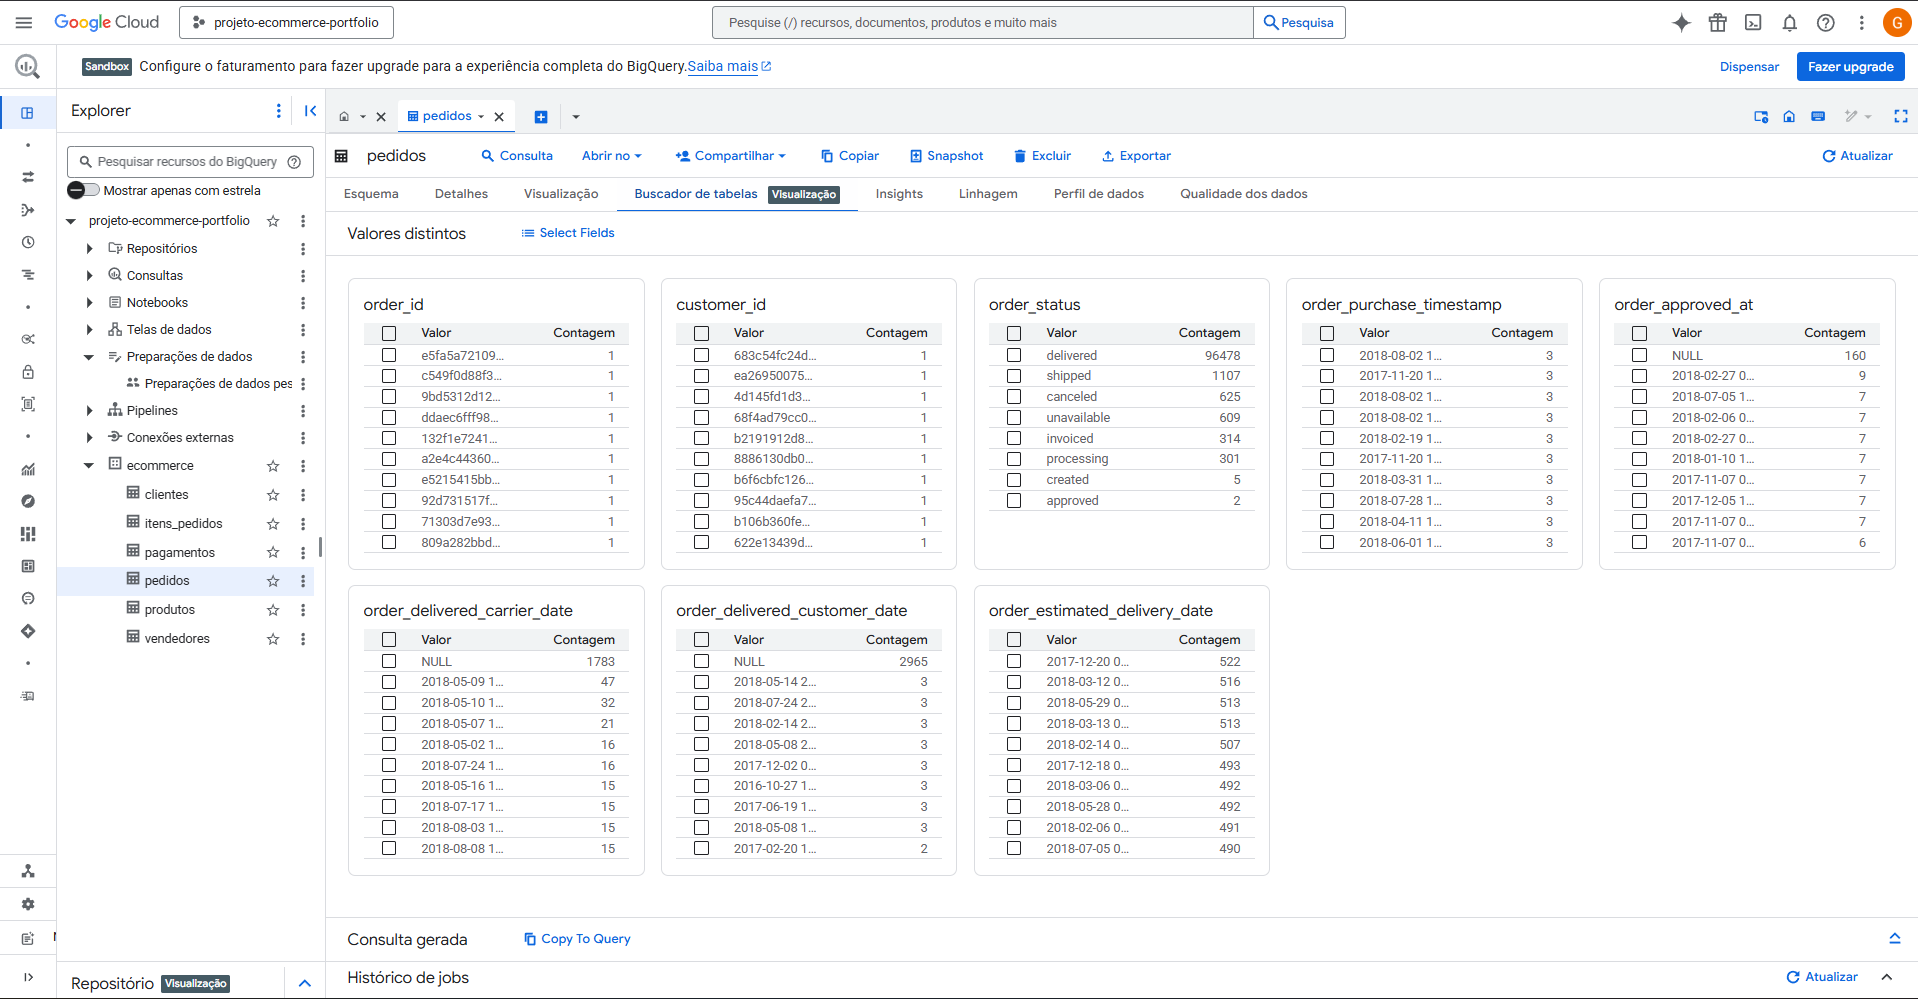

# Schema do Banco de Dados

## Código para extrair do schema em formato de texto

In [ ]:
# 1. Instala a biblioteca do Google Cloud para o BigQuery
!pip install google-cloud-bigquery pandas

# 2. Autentica sua conta do Google no ambiente do Colab
from google.colab import auth
auth.authenticate_user()

print('Autenticação concluída.')

Autenticação concluída.


In [ ]:
from google.cloud import bigquery

project_id = 'projeto-ecommerce-portfolio'
dataset_id = 'ecommerce'

# Inicia o cliente do BigQuery
client = bigquery.Client(project=project_id)

# Busca as tabelas no dataset
tables = client.list_tables(dataset_id)

print(f"--- Schema do Dataset: {dataset_id} ---")

for table in tables:
    # Monta o nome completo da tabela
    table_ref = client.dataset(dataset_id).table(table.table_id)

    # Obtém as informações detalhadas da tabela
    table_info = client.get_table(table_ref)

    print(f"\n[Tabela: {table.table_id}]")

    # Itera sobre cada coluna no schema da tabela e imprime os detalhes
    for column in table_info.schema:
        print(f"  - {column.name}: {column.field_type} ({column.mode})")

--- Schema do Dataset: ecommerce ---

[Tabela: clientes]
  - customer_id: STRING (NULLABLE)
  - customer_unique_id: STRING (NULLABLE)
  - customer_zip_code_prefix: INTEGER (NULLABLE)
  - customer_city: STRING (NULLABLE)
  - customer_state: STRING (NULLABLE)

[Tabela: itens_pedidos]
  - order_id: STRING (NULLABLE)
  - order_item_id: INTEGER (NULLABLE)
  - product_id: STRING (NULLABLE)
  - seller_id: STRING (NULLABLE)
  - shipping_limit_date: TIMESTAMP (NULLABLE)
  - price: FLOAT (NULLABLE)
  - freight_value: FLOAT (NULLABLE)

[Tabela: pagamentos]
  - order_id: STRING (NULLABLE)
  - payment_sequential: INTEGER (NULLABLE)
  - payment_type: STRING (NULLABLE)
  - payment_installments: INTEGER (NULLABLE)
  - payment_value: FLOAT (NULLABLE)

[Tabela: pedidos]
  - order_id: STRING (NULLABLE)
  - customer_id: STRING (NULLABLE)
  - order_status: STRING (NULLABLE)
  - order_purchase_timestamp: TIMESTAMP (NULLABLE)
  - order_approved_at: TIMESTAMP (NULLABLE)
  - order_delivered_carrier_date: TIMES

## Imagem do Schema

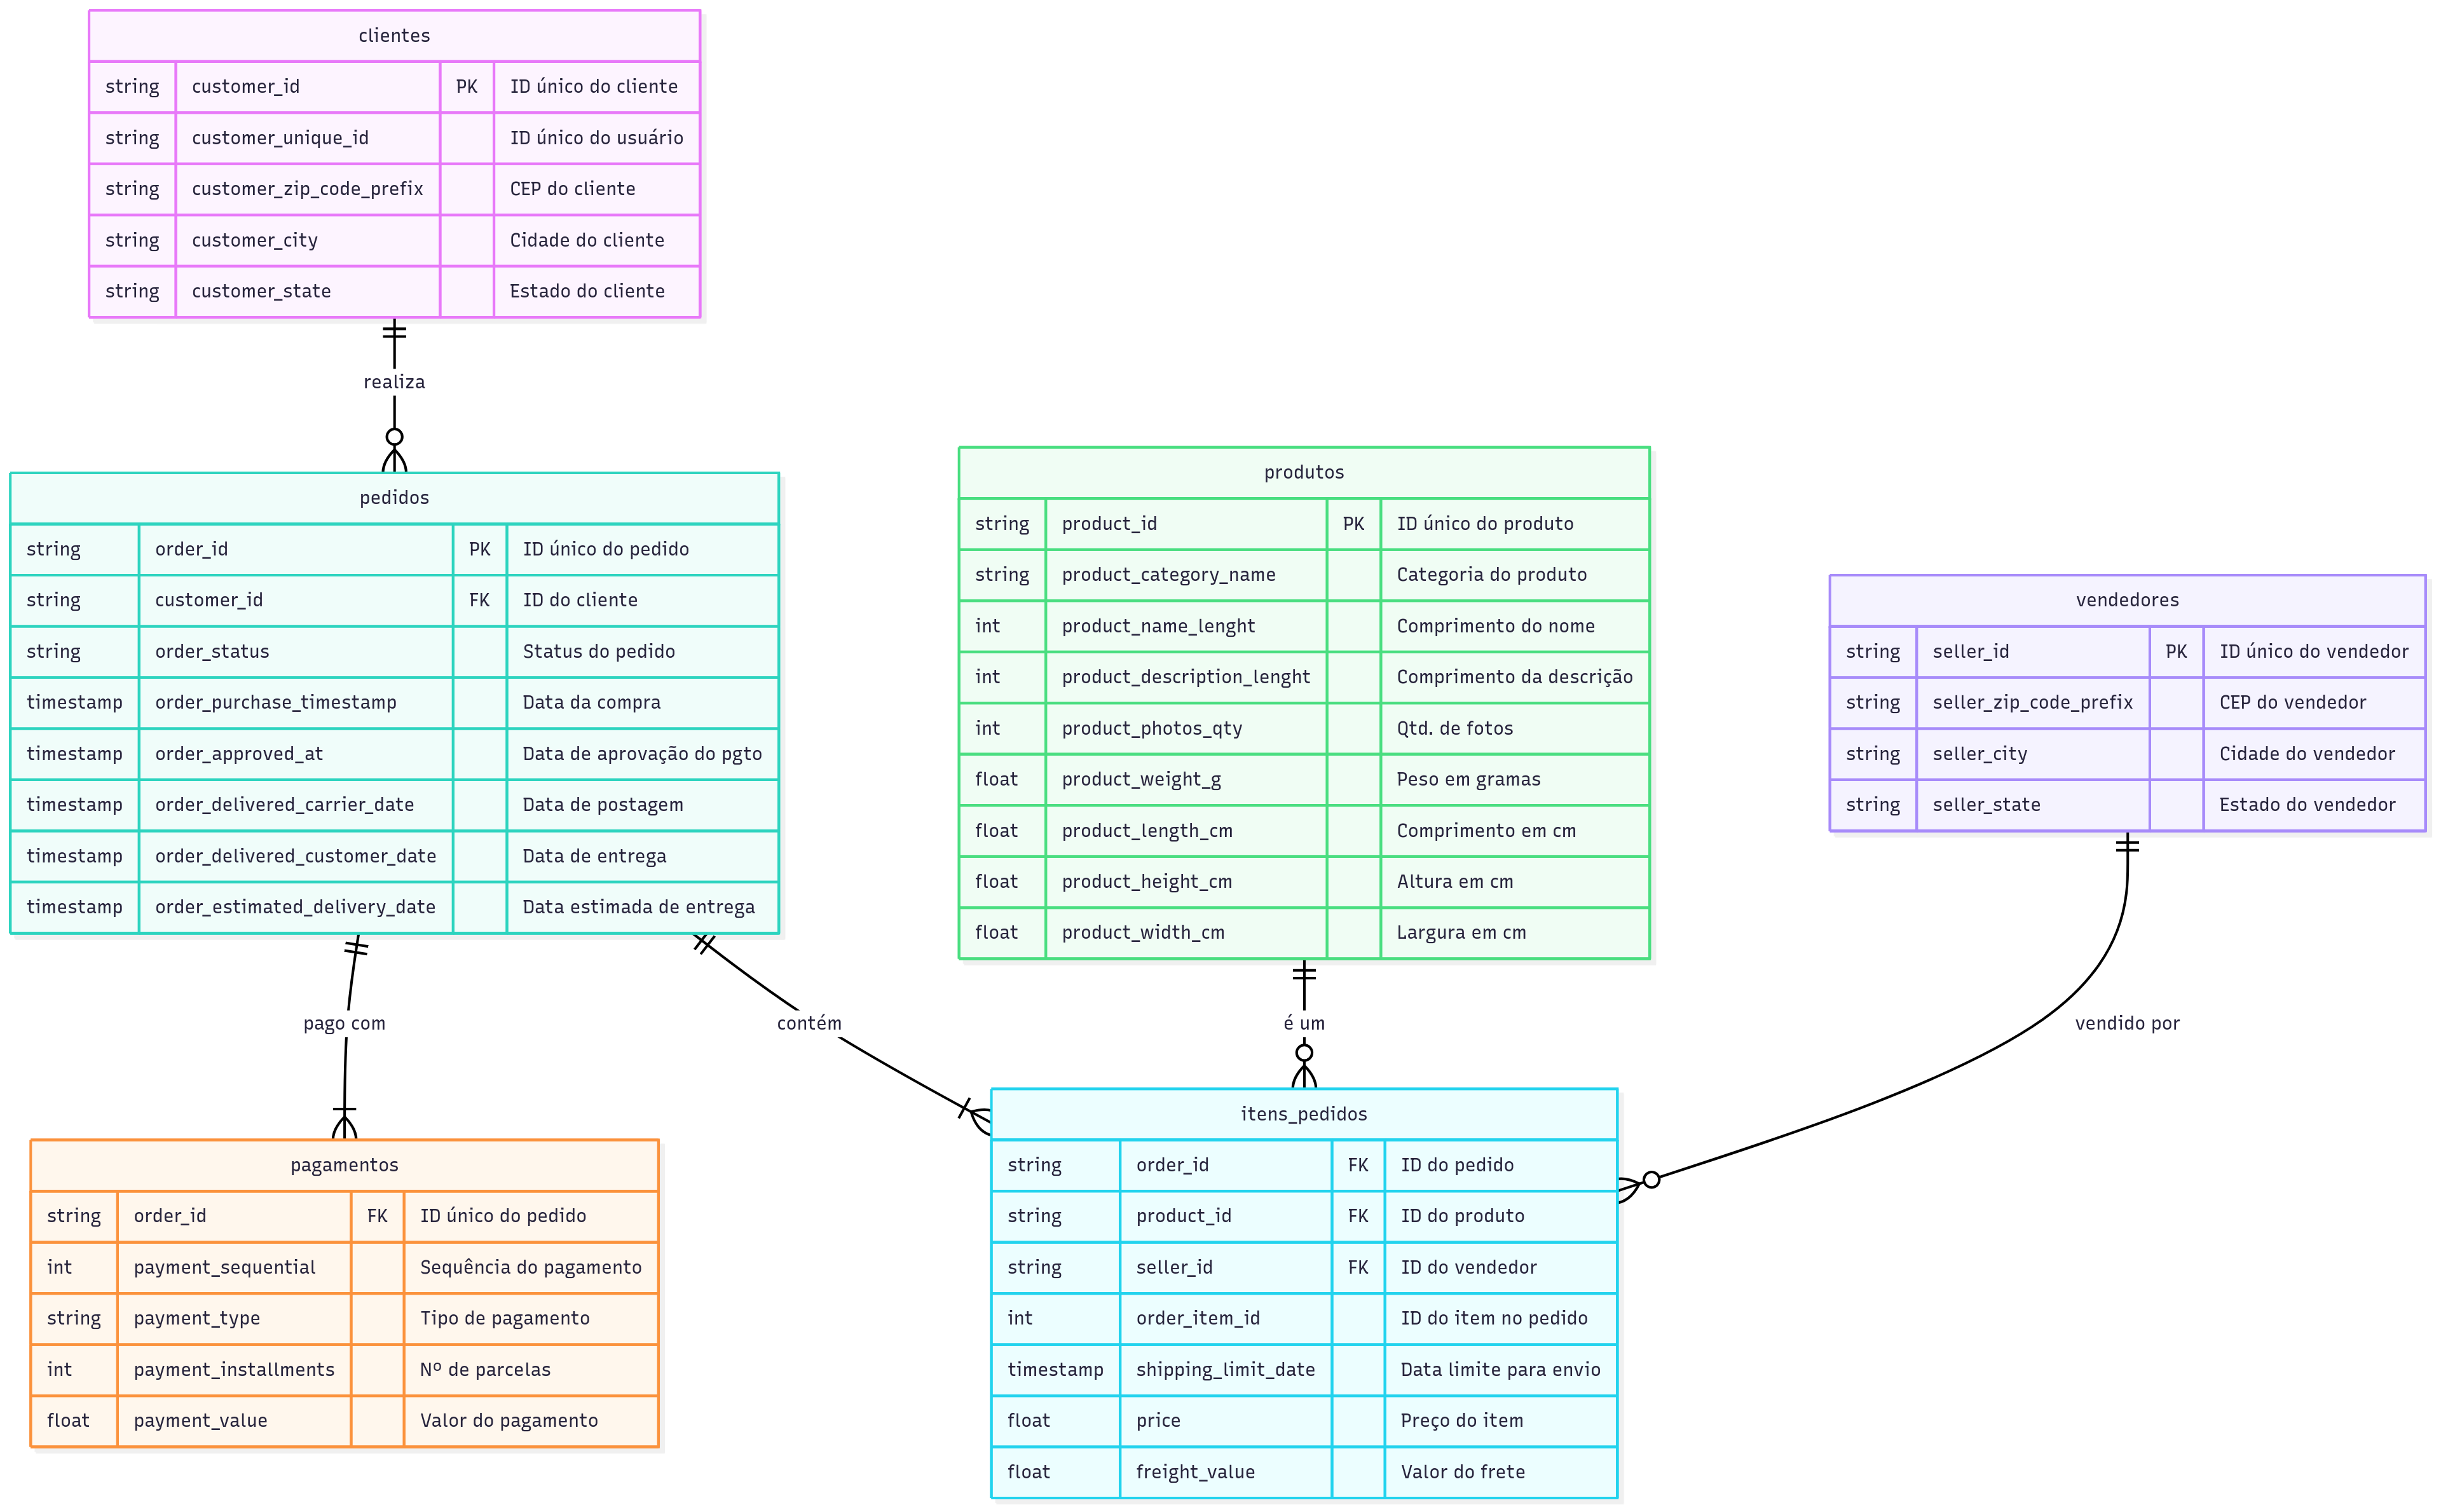

# **Análise Exploratória com SQL**

### Consultas iniciais para conhecer as tabelas

```
SELECT * FROM `projeto-ecommerce-portfolio.ecommerce.pedidos` LIMIT 10;

SELECT * FROM `projeto-ecommerce-portfolio.ecommerce.pagamentos` LIMIT 10;

SELECT * FROM `projeto-ecommerce-portfolio.ecommerce.itens_pedidos` LIMIT 10;

SELECT * FROM `projeto-ecommerce-portfolio.ecommerce.produtos` LIMIT 10;

SELECT * FROM `projeto-ecommerce-portfolio.ecommerce.vendedores` LIMIT 10;

SELECT * FROM `projeto-ecommerce-portfolio.ecommerce.clientes` LIMIT 10;
```

###Consulta para verificar o total de pedidos
```
SELECT
  COUNT(order_id) AS qtd_pedidos
FROM
  `projeto-ecommerce-portfolio.ecommerce.pedidos`;
```
Resultado: 99441

---
###Consullta para verificação de pedidos por status
```
SELECT
  order_status,
  COUNT(order_id) AS qtd_pedidos
FROM
  `projeto-ecommerce-portfolio.ecommerce.pedidos`
GROUP BY
  order_status
ORDER BY
  qtd_pedidos DESC;
```

Resultado: A maioria dos pedidos (96.478 de 99.441) possui o status delivered.

Para garantir a relevância das análises de vendas e receita, focaremos nosso estudo nos 96.478 pedidos que foram confirmados e entregues ao cliente.

###Consulta para verificação do tempo
```
SELECT
  MIN(order_purchase_timestamp) AS pedido_mais_antigo,
  MAX(order_purchase_timestamp) AS pedido_mais_recente
FROM
  `projeto-ecommerce-portfolio.ecommerce.pedidos`;
```




Resultado:
pedido_mais_antigo: 2016-09-04
pedido_mais_velho:  2018-10-17

A base de dados abrange um período de aproximadamente 25 meses, de Setembro de 2016 a Outubro de 2018.


###Consulta para pagamentos mais usados:

```
SELECT
  payment_type AS tipo_pagamento,
  COUNT(*) AS total_usos,
  ROUND(AVG(payment_value), 2) AS ticket_medio
FROM
  `projeto-ecommerce-portfolio.ecommerce.pagamentos`
GROUP BY
  tipo_pagamento
ORDER BY
  total_usos DESC;
```

Resultado: Tipo de pagamento mais usado: Cartão de crédito e com maior ticket médio.

A preferência massiva pelo cartão de crédito indica que estratégias de parcelamento e promoções atreladas a este método de pagamento são essenciais para o negócio

###Consulta para valor médio do Frete por Estado do Cliente

```
SELECT
  c.customer_state AS estado_cliente,
  COUNT(o.order_id) AS numero_de_pedidos,
  ROUND(AVG(oi.freight_value), 2) AS frete_medio
FROM
  `projeto-ecommerce-portfolio.ecommerce.clientes` AS c
JOIN
  `projeto-ecommerce-portfolio.ecommerce.pedidos` AS o
  ON c.customer_id = o.customer_id
JOIN
  `projeto-ecommerce-portfolio.ecommerce.itens_pedidos` AS oi
  ON o.order_id = oi.order_id
WHERE
  o.order_status = 'delivered'
GROUP BY
  estado_cliente
ORDER BY
  frete_medio DESC;
```
Resultado:  São Paulo tem o maior volume de pedidos e o frete mais baratos, isso mostra como a densidade populacional e a proximidade com centros de distribuição impactam a viabilidade do e-commerce.


### Consulta para categoria de produtos mais vendidos



```
SELECT
  -- COALESCE para tratar categorias nulas como 'Nao Categorizado'
  COALESCE(p.product_category_name, 'Nao Categorizado') AS categoria_produto,
  COUNT(oi.order_id) AS total_itens_vendidos
FROM
  `projeto-ecommerce-portfolio.ecommerce.itens_pedidos` AS oi
JOIN
  `projeto-ecommerce-portfolio.ecommerce.produtos` AS p
  ON oi.product_id = p.product_id
JOIN
  `projeto-ecommerce-portfolio.ecommerce.pedidos` AS o
  ON oi.order_id = o.order_id
WHERE
  o.order_status = 'delivered'
GROUP BY
  categoria_produto
ORDER BY
  total_itens_vendidos DESC
LIMIT 10;
```

Resultado:

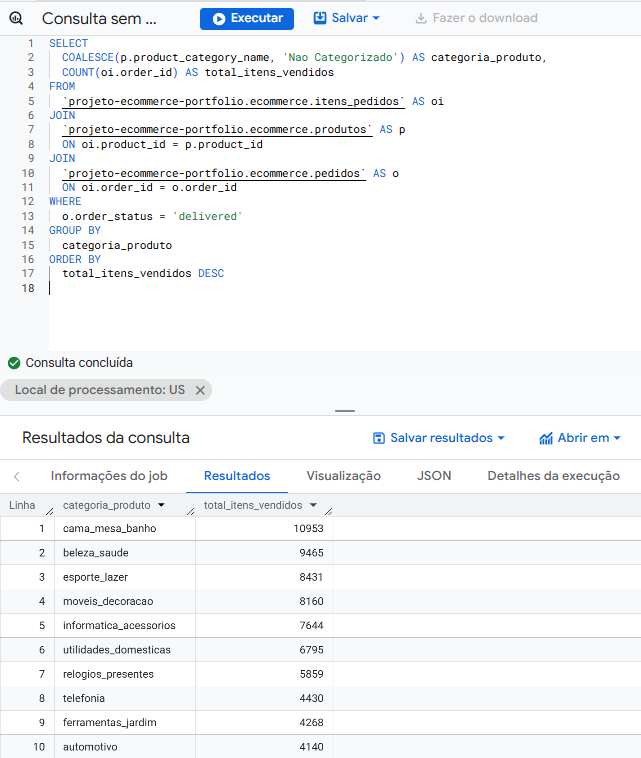


A consulta mostra que as categorias mais vendidas estão concentradas em produtos para o lar (cama_mesa_banho, moveis_decoracao, utilidades_domesticas) e bem-estar pessoal (beleza_saude, esporte_lazer). Isso sugere que o perfil principal do consumidor da plataforma busca itens para o dia a dia e para cuidados pessoais.

### Consulta de análise de vendas e receita ao longo do tempo



```
SELECT
  -- Formata a data da compra para o formato 'Ano-Mês'
  FORMAT_TIMESTAMP('%Y-%m', o.order_purchase_timestamp) AS ano_mes,
  -- Pedidos únicos para evitar duplicatas do JOIN
  COUNT(DISTINCT o.order_id) AS numero_de_pedidos,
  -- Soma o valor de todos os pagamentos para obter a receita
  ROUND(SUM(p.payment_value), 2) AS receita_total
FROM
  `projeto-ecommerce-portfolio.ecommerce.pedidos` AS o
JOIN
  `projeto-ecommerce-portfolio.ecommerce.pagamentos` AS p
  ON o.order_id = p.order_id
WHERE
  o.order_status = 'delivered'
GROUP BY
  ano_mes
ORDER BY
  ano_mes;
```

Resultado: Há um grande volume de vendas no final do ano de 2017, possivelmente por conta de natal e black friday.
Nota-se que a empresa tem dados de vendas em 2016 muito baixos, acreditamos se tratar de uma fase inicial da Olist, logo, não levaremos em consideração os dois meses de 2016 com vendas. Com filtro a consulta fica desta forma:



```
SELECT
  -- Extrai e formata a data da compra para o formato 'Ano-Mês'
  FORMAT_TIMESTAMP('%Y-%m', o.order_purchase_timestamp) AS ano_mes,
  -- Conta o número de pedidos únicos
  COUNT(DISTINCT o.order_id) AS numero_de_pedidos,
  -- Soma o valor de todos os pagamentos para obter a receita
  ROUND(SUM(p.payment_value), 2) AS receita_total
FROM
  `projeto-ecommerce-portfolio.ecommerce.pedidos` AS o
JOIN
  `projeto-ecommerce-portfolio.ecommerce.pagamentos` AS p
  ON o.order_id = p.order_id
WHERE
  o.order_status = 'delivered'
  -- Filtro do ano
  AND EXTRACT(YEAR FROM o.order_purchase_timestamp) > 2016
GROUP BY
  ano_mes
ORDER BY
  ano_mes;
```

###Criando a VIEW

```
-- Cria uma VIEW chamada 'vw_vendas_consolidadas'
CREATE VIEW `projeto-ecommerce-portfolio.ecommerce.vw_vendas_consolidadas` AS

-- Inicia uma CTE para agregar os dados de pagamento por pedido
WITH pagamentos_pedidos AS (
  SELECT
    order_id,
    SUM(payment_value) AS valor_total_pagamento,
    SUM(payment_installments) AS total_parcelas,
    STRING_AGG(payment_type, ', ') AS metodos_pagamento
  FROM
    `projeto-ecommerce-portfolio.ecommerce.pagamentos`
  GROUP BY
    order_id
)

-- Consulta principal que une todas as tabelas
SELECT
  -- Chaves (IDs)
  oi.order_id,
  oi.product_id,
  o.customer_id,
  oi.seller_id,

  -- Informações do Pedido e Entrega
  o.order_status,
  o.order_purchase_timestamp AS data_compra,
  o.order_approved_at AS data_aprovacao_pagamento,
  o.order_delivered_carrier_date AS data_postagem,
  o.order_delivered_customer_date AS data_entrega,
  o.order_estimated_delivery_date AS data_estimada_entrega,

  -- Informações do Cliente
  c.customer_city AS cidade_cliente,
  c.customer_state AS estado_cliente,

  -- Informações do Produto
  COALESCE(p.product_category_name, 'nao_categorizado') AS categoria_produto,
  p.product_weight_g,

  -- Informações dos Itens do Pedido
  oi.price AS preco_item,
  oi.freight_value AS valor_frete,

  -- Informações de Pagamento (da nossa CTE)
  pp.valor_total_pagamento,
  pp.total_parcelas,
  pp.metodos_pagamento,

  -- Informações do Vendedor
  s.seller_city AS cidade_vendedor,
  s.seller_state AS estado_vendedor

FROM
  `projeto-ecommerce-portfolio.ecommerce.itens_pedidos` AS oi

-- Unindo as tabelas
LEFT JOIN `projeto-ecommerce-portfolio.ecommerce.pedidos` AS o ON oi.order_id = o.order_id
LEFT JOIN `projeto-ecommerce-portfolio.ecommerce.clientes` AS c ON o.customer_id = c.customer_id
LEFT JOIN `projeto-ecommerce-portfolio.ecommerce.produtos` AS p ON oi.product_id = p.product_id
LEFT JOIN `projeto-ecommerce-portfolio.ecommerce.vendedores` AS s ON oi.seller_id = s.seller_id
LEFT JOIN pagamentos_pedidos AS pp ON oi.order_id = pp.order_id

-- Aplicando os filtros de limpeza
WHERE
  o.order_status = 'delivered'
  AND EXTRACT(YEAR FROM o.order_purchase_timestamp) > 2016;
```

Resultado: Unimos as colunas de todas as tabelas importantes em um único lugar.

### View criada:


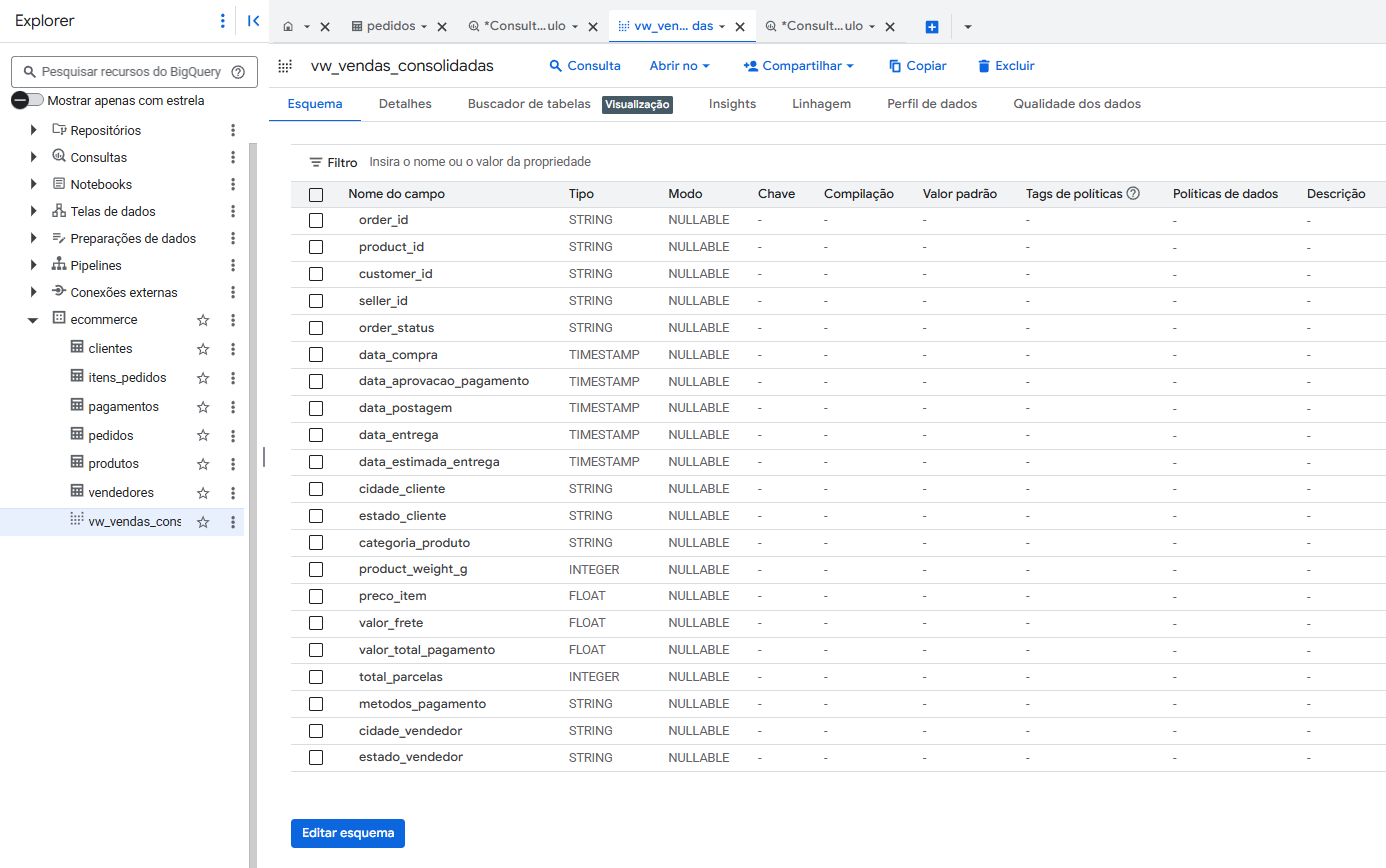

# Criando o DataFrame com Python

In [ ]:
import pandas as pd
from google.cloud import bigquery

# (Código de autenticação, se necessário)

project_id = 'projeto-ecommerce-portfolio'
client = bigquery.Client(project=project_id)

# --- CONSULTA SQL FINAL E COMPLETA PARA O PROJETO ---
sql_query_definitivo = """
WITH
  pagamentos_por_pedido AS (
    SELECT
      order_id,
      SUM(payment_value) AS valor_total_pagamento
    FROM
      `projeto-ecommerce-portfolio.ecommerce.pagamentos`
    GROUP BY
      order_id
  )
SELECT
  -- IDs
  o.order_id,
  c.customer_unique_id,
  oi.product_id,
  -- Datas
  o.order_purchase_timestamp AS data_compra,
  o.order_delivered_customer_date AS data_entrega,
  DATE_DIFF(o.order_delivered_customer_date, o.order_purchase_timestamp, DAY) AS tempo_entrega_dias,
  -- Valores do Item
  oi.price AS preco_item,
  oi.freight_value AS valor_frete,
  -- Valor Total do Pedido (da CTE)
  pp.valor_total_pagamento,
  -- Demais informações
  c.customer_state AS estado_cliente,
  COALESCE(pr.product_category_name, 'nao_categorizado') AS categoria_produto,
  pr.product_weight_g,
  pr.product_length_cm,
  pr.product_height_cm,
  pr.product_width_cm
FROM
  `projeto-ecommerce-portfolio.ecommerce.itens_pedidos` AS oi
JOIN
  `projeto-ecommerce-portfolio.ecommerce.pedidos` AS o ON oi.order_id = o.order_id
JOIN
  `projeto-ecommerce-portfolio.ecommerce.clientes` AS c ON o.customer_id = c.customer_id
JOIN
  `projeto-ecommerce-portfolio.ecommerce.produtos` AS pr ON oi.product_id = pr.product_id
LEFT JOIN
  pagamentos_por_pedido AS pp ON o.order_id = pp.order_id
WHERE
  o.order_status = 'delivered'
  AND EXTRACT(YEAR FROM o.order_purchase_timestamp) > 2016;
"""

# Criação do DataFrame
df_vendas = client.query(sql_query_definitivo).to_dataframe()

print("DataFrame 'df_vendas' carregado com sucesso!")
print(f"Total de Linhas: {len(df_vendas)}")
print(f"Total de Colunas: {len(df_vendas.columns)}")
display(df_vendas.head())

DataFrame 'df_vendas' carregado com sucesso!
Total de Linhas: 109880
Total de Colunas: 15


,order_id,customer_unique_id,product_id,data_compra,data_entrega,tempo_entrega_dias,preco_item,valor_frete,valor_total_pagamento,estado_cliente,categoria_produto,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,df6e0cd0f23b4735b02cb6d9279bb310,7d9d77225e11b7722d0631d6243178e3,c384df04227582c085d6524937a3768a,2017-01-16 21:18:10+00:00,2017-01-24 19:16:47+00:00,7,345.00,27.64,372.64,MG,automotivo,21800,60,60,20
1,49268496ecf8148bd16540c2a23c6c70,25f287951bd4fd3e2ab42be9b6ad356a,085481a1b9ec9eaa346ae0a39bd3c340,2017-01-19 23:12:08+00:00,2017-02-01 18:06:52+00:00,12,109.50,37.71,147.21,SP,moveis_decoracao,5070,56,38,48
2,b174fa32929e4af3622213e835cfa84a,4d5db20ccc7f8a5f045b475d9fc6d8ec,6d811b6e8cada9a8f7f38bb315620e1b,2017-01-09 21:31:15+00:00,2017-01-18 17:05:11+00:00,8,129.00,22.37,151.37,SP,esporte_lazer,8700,25,60,40
3,a9ad904bde6787e355771489eef73012,eb5bdaa9ace81785a5c3526bbd8d759b,beda52fd19ab7f39cadee87a7f3f472f,2017-01-23 21:38:10+00:00,2017-02-07 08:47:52+00:00,14,112.99,15.55,257.08,RJ,ferramentas_jardim,900,24,41,24
4,a9ad904bde6787e355771489eef73012,eb5bdaa9ace81785a5c3526bbd8d759b,beda52fd19ab7f39cadee87a7f3f472f,2017-01-23 21:38:10+00:00,2017-02-07 08:47:52+00:00,14,112.99,15.55,257.08,RJ,ferramentas_jardim,900,24,41,24


##Análise de Dados Faltantes (Valores Nulos)
Ao executar o comando .info(), foi possível observar que a contagem de registros em algumas colunas era inferior ao total de 109.880 linhas, indicando a presença de valores nulos.

As colunas afetadas foram:

```
data_aprovacao_pagamento

data_postagem

data_entrega

product_weight_g
```


### Hipótese e Conclusão:

A investigação revelou que os dados faltantes nas colunas de data estão diretamente ligados ao processo de negócio. A data_compra é registrada quando um pedido é criado (ex: um boleto é gerado), mas as datas subsequentes (aprovação, postagem, entrega) só são preenchidas se o pagamento for efetivamente confirmado. Portanto, os valores nulos representam, em sua maioria, pedidos que foram criados mas não pagos (ex: boleto expirado).

Para a coluna product_weight_g, os valores nulos são provavelmente resultado de falhas no cadastro dos produtos.

Como a quantidade de dados faltantes é muito pequena (< 0.02%) em relação ao volume total e sua causa é explicável, optei por não remover ou tratar essas linhas nesta fase da análise, prosseguindo com o conhecimento de sua existência.

### Granularidade dos Dados:

A VIEW contém 109.880 linhas, que representam os itens individuais dos pedidos. Como um único pedido pode conter vários produtos, este número é maior que o total de pedidos únicos. Com base nisso, calculamos uma métrica de negócio inicial:

109.880 (itens) / 96.478 (pedidos) = 1,14 itens por pedido

Em média, cada compra na plataforma contém 1,14 produtos.


### Qualidade dos Dados
A saída do .info() confirma a alta qualidade dos dados para análise. Os tipos de dados (Dtype) foram reconhecidos corretamente pelo Pandas (datas como datetime64, valores monetários como float64), e os poucos dados faltantes, conforme investigado anteriormente, são explicáveis pelo processo de negócio (ex: boletos não pagos) e não exigem tratamento nesta fase.

## Resumo Estatistico

In [ ]:
# Função describe para fazer um resumo estatistico do DataFrame
df_vendas.describe()

,tempo_entrega_dias,preco_item,valor_frete,valor_total_pagamento,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,109872.0,109880.000000,109880.000000,109880.000000,109862.0,109862.0,109862.0,109862.0
mean,11.985993,119.958383,19.949881,179.417491,2089.445395,30.13882,16.549389,22.984972
std,9.433554,182.346158,15.703594,271.517948,3741.977242,16.120421,13.40992,11.690344
min,0.0,0.850000,0.000000,9.590000,0.0,7.0,2.0,6.0
25%,6.0,39.900000,13.080000,65.560000,300.0,18.0,8.0,15.0
50%,10.0,74.900000,16.260000,114.330000,700.0,25.0,13.0,20.0
75%,15.0,134.170000,21.150000,194.910000,1800.0,38.0,20.0,30.0
max,209.0,6735.000000,409.680000,13664.080000,40425.0,105.0,105.0,118.0


## Validação de números

Esse bloco de código serve para validar as informações no Power BI, SQL e Python

In [ ]:
# --- VALIDAÇÃO ---

receita_py_corrigida = df_vendas['valor_total_pagamento'].sum()
clientes_py_corrigidos = df_vendas['customer_unique_id'].nunique()
pedidos_py_corrigidos = df_vendas['order_id'].nunique()

print(f"Receita Total: {round(receita_py_corrigida, 2)}")
print(f"Clientes Únicos: {clientes_py_corrigidos}")
print(f"Pedidos Únicos: {pedidos_py_corrigidos}")

Receita Total: 19714393.88
Clientes Únicos: 93104
Pedidos Únicos: 96211


## Análise Estatística Descritiva
Com os dados carregados no Pandas, utilizamos o método .describe() para gerar um resumo estatístico das colunas numéricas. A análise, com foco na coluna preco_item, revelou insights importantes sobre a distribuição dos preços dos produtos.

### Observações sobre preco_item:

Disparidade entre Média e Máximo: O preço médio (mean) de um item é de R\$ 119,96, enquanto o preço máximo (max) registrado é de R\$6735.

Uma diferença tão grande é um forte indicativo da presença de outliers (valores muito acima do padrão).

Média vs. Mediana: A mediana (50%), que representa o valor central dos dados, é de apenas R$ 74.90. O fato de a média ser significativamente maior que a mediana confirma que a distribuição dos preços é assimétrica positiva (positive skew). Isso significa que a maioria dos produtos vendidos tem valor baixo, e alguns poucos itens de alto valor estão "puxando" a média para cima.

Concentração dos Dados: O 75º percentil (75%) nos informa que 75% de todos os itens vendidos custam até R$ 134.17, o que reforça a conclusão de que os produtos de valor muito elevado são exceções à regra.

### Conclusão:
A análise estatística demonstra que, para entender o "preço típico" de um produto nesta loja, a mediana (R$ 74.90) é uma métrica muito mais confiável e representativa do que a média. A próxima etapa será visualizar essa distribuição para confirmar graficamente a presença desses outliers e a concentração de preços na faixa mais baixa.

# Análise de preços por item

## Histograma de preço

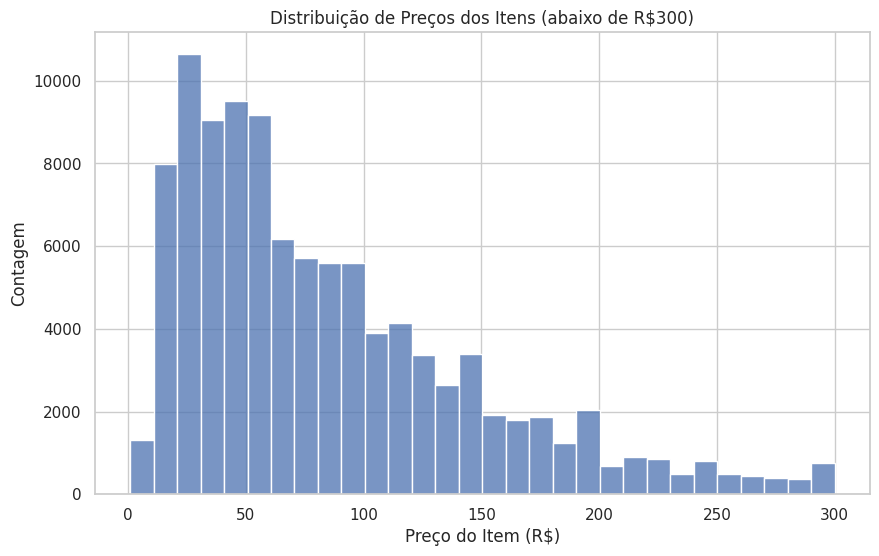

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define o estilo do gráfico
sns.set_theme(style="whitegrid")

# Cria uma figura para o gráfico
plt.figure(figsize=(10, 6))

# Filtra o DataFrame para pegar apenas os itens com preço abaixo de 300
df_preco_filtrado = df_vendas[df_vendas['preco_item'] < 300]

# Cria o histograma
sns.histplot(data=df_preco_filtrado, x='preco_item', bins=30)

# Adiciona um título e rótulos
plt.title('Distribuição de Preços dos Itens (abaixo de R$300)')
plt.xlabel('Preço do Item (R$)')
plt.ylabel('Contagem')

# Salva o gráfico como uma imagem
plt.savefig('histograma_precos.png')

# Mostra o gráfico
plt.show()

### Observações sobre o histograma
Concentração de Volume: A grande maioria dos itens vendidos se acumula na faixa de preço mais baixa, com um pico claro antes dos R\$ 60. O método describe() nos mostrou que a mediana está em R\$ 74,90.

Falta de Normalidade: A distribuição não é simétrica, não há uma curva normal.

## Box-plot de preços sem filtro

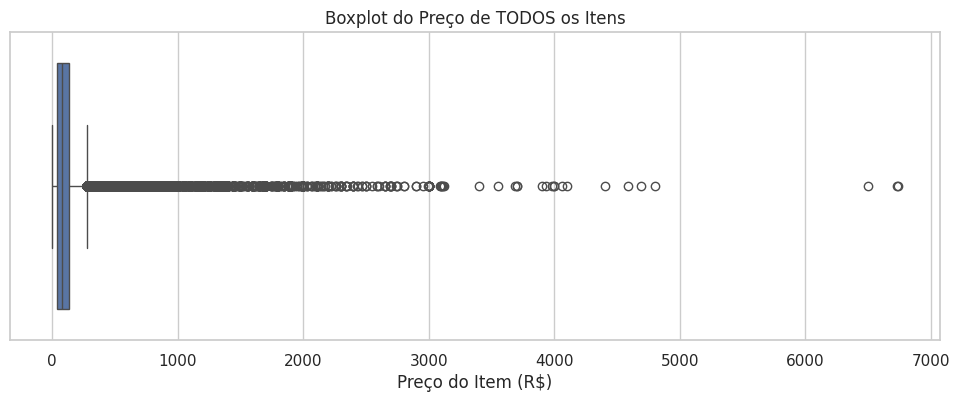

In [ ]:
# Estilo do gráfico
sns.set_theme(style="whitegrid")

# --- Boxplot 1 com todos os dados (para visualização de outliers) ---
plt.figure(figsize=(12, 4))
sns.boxplot(x=df_vendas['preco_item'])
plt.title('Boxplot do Preço de TODOS os Itens')
plt.xlabel('Preço do Item (R$)')
plt.savefig('boxplot_preco_completo.png')
plt.show()

### Observações sobre o box-plot
O boxplot dos dados completos aparece "esmagado", com a caixa principal reduzida a um pequeno traço, mas é extremamente eficaz em mostrar a escala real dos outliers.

## Box-plot com filtro

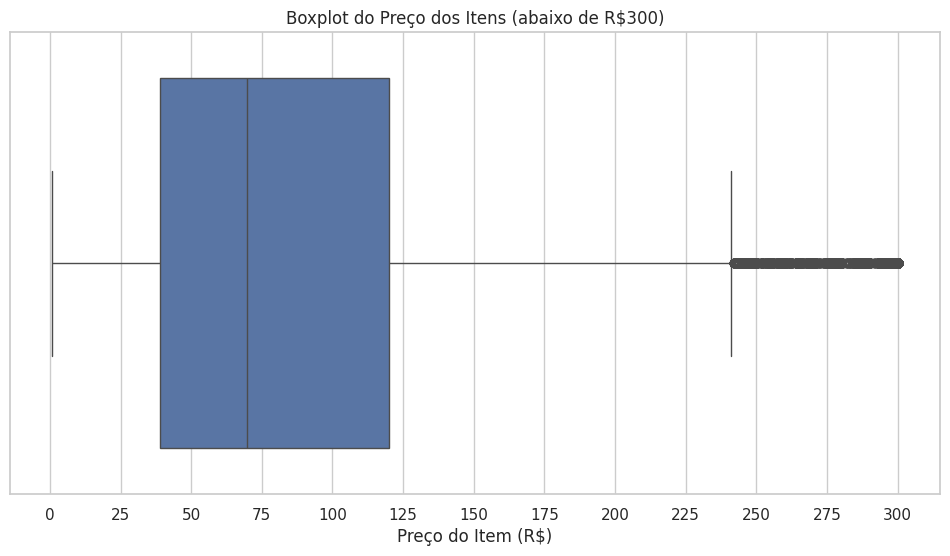

In [ ]:
# --- Boxplot 2 com dados filtrados (para ver a distribuição principal) ---
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_preco_filtrado['preco_item']) # Usando o df_preco_filtrado usado no histograma
plt.title('Boxplot do Preço dos Itens (abaixo de R$300)')
plt.xlabel('Preço do Item (R$)')
plt.xticks(ticks=[t for t in range(0, 301, 25)]) # Melhora a leitura do eixo x
plt.savefig('boxplot_preco_filtrado.png')
plt.show()

In [ ]:
# Estatisticas do DataFrame filtrado (valores até R$300)
print("Estatísticas dos itens com preço abaixo de R$ 300:")
df_preco_filtrado.describe()

Estatísticas dos itens com preço abaixo de R$ 300:


,tempo_entrega_dias,preco_item,valor_frete,valor_total_pagamento,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,103193.0,103200.000000,103200.000000,103200.000000,103183.0,103183.0,103183.0,103183.0
mean,11.873538,86.743972,18.687589,142.254678,1833.663336,29.792437,15.974221,22.641937
std,9.311976,62.920004,12.266897,147.565143,3165.616428,15.817821,12.786782,11.369676
min,0.0,0.850000,0.000000,9.590000,0.0,7.0,2.0,6.0
25%,6.0,38.990000,12.830000,63.455000,270.0,18.0,8.0,15.0
50%,10.0,69.900000,16.070000,107.205000,650.0,25.0,12.0,20.0
75%,15.0,119.900000,19.970000,173.880000,1650.0,37.0,20.0,30.0
max,209.0,299.990000,299.160000,3195.730000,40425.0,105.0,105.0,118.0


### Observações sobre o box-plot filtrado

Para entender o comportamento da grande maioria das vendas, a análise foi focada nos produtos com preço abaixo de R$ 300. Esta filtragem nos permitiu dar um "zoom" na parte mais densa da distribuição.

###Boxplot Filtrado e Estatísticas Correspondentes:

Observação: A mediana (50%) dos dados filtrados é de R\$ 69,90, e a média é de R\$ 86,74. O 3º quartil (75%) é de R\$ 119,90.

Insight: Este gráfico detalhado confirma que o "coração do negócio" – a faixa de preço que abrange metade de todos os itens vendidos – está entre R\$ 38,99 (25%) e R\$ 119,90 (75%). A proximidade entre a média e a mediana neste grupo filtrado sugere uma distribuição mais comportada, mas a assimetria dentro da caixa ainda indica uma maior concentração nos valores mais baixos.

## Conclusão Final sobre a Distribuição de Preços

A análise combinada dos dois conjuntos de gráficos e estatísticas nos permite concluir que o modelo de negócio da plataforma é focado em alto volume de vendas de produtos com preço acessível. A análise visual, através do histograma e do boxplot, confirma a hipótese levantada pela análise estatística do .describe(): a de que a mediana é a métrica mais representativa do preço típico. Os produtos de alto valor existem, mas são exceções (outliers) e não representam o perfil de venda principal da empresa.

In [ ]:
# O DataFrame 'df_vendas' é o nosso DataFrame mestre, com granularidade de item
# Para calcular a receita total sem duplicidade, primeiro pegamos os pedidos únicos e seu valor
df_pedidos_unicos = df_vendas.drop_duplicates(subset=['order_id'])

# Agora, calculamos as métricas a partir desta tabela de pedidos únicos
receita_total_py_correta = df_pedidos_unicos['valor_total_pagamento'].sum()
pedidos_unicos_py_corretos = len(df_pedidos_unicos) # Contagem de linhas já é a contagem de pedidos únicos

ticket_medio_py_correto = receita_total_py_correta / pedidos_unicos_py_corretos

print("--- Validação Final e Correta ---")
print(f"Receita Total Validada no Python: R$ {receita_total_py_correta:.2f}")
print(f"Nº de Pedidos Únicos Validado no Python: {pedidos_unicos_py_corretos}")
print(f"Ticket Médio Validado no Python: R$ {ticket_medio_py_correto:.2f}")

--- Validação Final e Correta ---
Receita Total Validada no Python: R$ 15375875.44
Nº de Pedidos Únicos Validado no Python: 96211
Ticket Médio Validado no Python: R$ 159.81


# Análise de produtos mais caros

In [ ]:
# 1. Ordena o DataFrame pela coluna 'preco_item' em ordem decrescente
df_mais_caros = df_vendas.sort_values(by='preco_item', ascending=False)

# 2. Seleciona apenas as colunas que nos interessam para esta análise
colunas_interesse = ['categoria_produto', 'preco_item', 'product_id']

# 3. Exibe os 15 produtos mais caros
print("Top 15 produtos mais caros vendidos:")
display(df_mais_caros[colunas_interesse].head(15))

Top 15 produtos mais caros vendidos:


,categoria_produto,preco_item,product_id
74,utilidades_domesticas,6735.00,489ae2aa008f021502940f251d4cce7f
83094,pcs,6729.00,69c590f7ffc7bf8db97190b6cb6ed62e
97846,artes,6499.00,1bdf5e6731585cf01aa8169c7028d6ad
107760,eletroportateis,4799.00,a6492cc69376c469ab6f61d8f44de961
626,eletroportateis,4690.00,c3ed642d592594bb648ff4a04cee2747
47616,pcs,4590.00,259037a6a41845e455183f89c5035f18
7351,instrumentos_musicais,4399.87,a1beef8f3992dbd4cd8726796aa69c53
45621,consoles_games,4099.99,6cdf8fc1d741c76586d8b6b15e9eef30
100289,esporte_lazer,4059.00,dd113cb02b2af9c8e5787e8f1f0722f6
49190,relogios_presentes,3999.90,6902c1962dd19d540807d0ab8fade5c6


## Observações sobre produtos mais caros:

Nossa análise completa nos mostrou que a empresa opera com dois tipos de catálogo muito distintos:

A "Cabeça" (The Head): São os produtos de alto volume e baixo custo, como cama_mesa_banho e beleza_saude. Eles são a base do negócio, vendem todos os dias e atraem a maioria dos clientes.

A "Cauda Longa" (The Long Tail): São os produtos de baixo volume e alto custo, como pcs, consoles_games e relogios_presentes. Eles vendem raramente, mas cada venda contribui com uma receita significativa.


### Conclusão Final da Análise de Produtos:
Nossa análise exploratória em Python, combinando estatísticas (.describe()) e visualizações (histograma e boxplot), provou que o negócio tem uma estratégia de produto diversificada. O volume principal vem de itens de baixo custo, mas o catálogo também inclui itens de nicho e de alto valor que, apesar de venderem pouco, provavelmente têm um impacto importante na receita total.

# Analise de frete

## Estatisticas do frete

In [ ]:
# Calcula a diferença entre a data de entrega e a data da compra
df_vendas['tempo_entrega'] = df_vendas['data_entrega'] - df_vendas['data_compra']

# A coluna 'tempo_entrega' é um tipo especial 'Timedelta'. Extração apenas do número de dias.
df_vendas['tempo_entrega_dias'] = df_vendas['tempo_entrega'].dt.days

# Resultado para os 5 primeiros pedidos
print("Coluna 'tempo_entrega_dias' calculada com sucesso!")
display(df_vendas[['order_id', 'data_compra', 'data_entrega', 'tempo_entrega_dias']].head())

# Resumo estatístico da nova coluna
print("\nEstatísticas do Tempo de Entrega (em dias):")
display(df_vendas['tempo_entrega_dias'].describe())

Coluna 'tempo_entrega_dias' calculada com sucesso!


,order_id,data_compra,data_entrega,tempo_entrega_dias
0,df6e0cd0f23b4735b02cb6d9279bb310,2017-01-16 21:18:10+00:00,2017-01-24 19:16:47+00:00,7.0
1,49268496ecf8148bd16540c2a23c6c70,2017-01-19 23:12:08+00:00,2017-02-01 18:06:52+00:00,12.0
2,b174fa32929e4af3622213e835cfa84a,2017-01-09 21:31:15+00:00,2017-01-18 17:05:11+00:00,8.0
3,a9ad904bde6787e355771489eef73012,2017-01-23 21:38:10+00:00,2017-02-07 08:47:52+00:00,14.0
4,a9ad904bde6787e355771489eef73012,2017-01-23 21:38:10+00:00,2017-02-07 08:47:52+00:00,14.0



Estatísticas do Tempo de Entrega (em dias):


,tempo_entrega_dias
count,109872.000000
mean,11.985993
std,9.433554
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


## Histrograma de frete filtrado

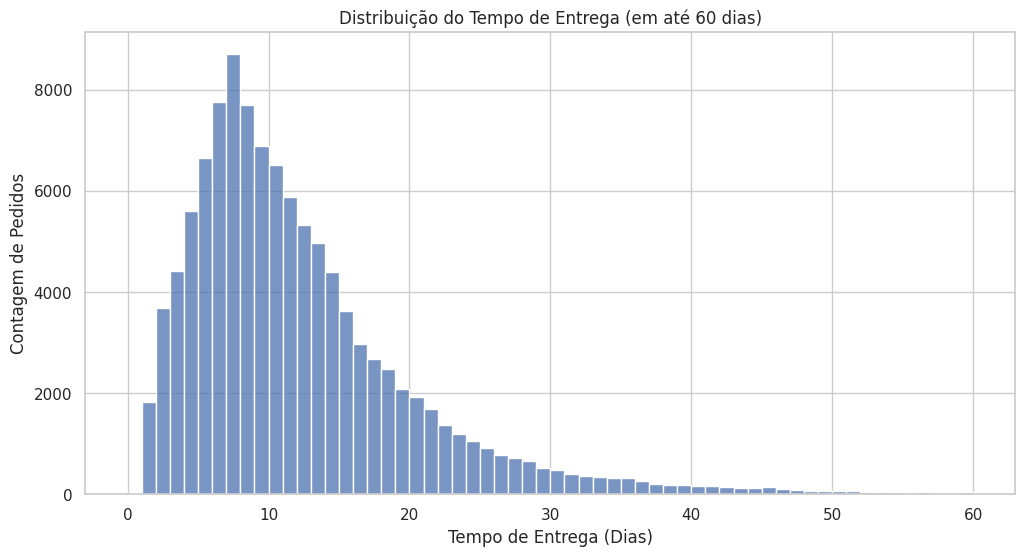

In [ ]:
# Estilo do gráfico
sns.set_theme(style="whitegrid")

# --- Histograma com dados filtrados (para a distribuição principal) ---
plt.figure(figsize=(12, 6))
# Filtra para visualização, mostrando entregas em até 60 dias para melhor visualização
df_entrega_filtrado = df_vendas[df_vendas['tempo_entrega_dias'] <= 60]
sns.histplot(data=df_entrega_filtrado, x='tempo_entrega_dias', bins=60) # 1 bin por dia
plt.title('Distribuição do Tempo de Entrega (em até 60 dias)')
plt.xlabel('Tempo de Entrega (Dias)')
plt.ylabel('Contagem de Pedidos')
plt.savefig('histograma_tempo_entrega.png')
plt.show()

## Análise do Histograma

Distribuição Assimétrica: O histograma mostra uma forte concentração de entregas ocorrendo nos primeiros dias. A curva é assimétrica à direita (right-skewed), com uma cauda longa que se estende para a direita.

Insight: Isso confirma que, embora a maioria das entregas seja rápida (concentradas em até 10-15 dias), existe um número menor, mas significativo, de pedidos que levam muito mais tempo. A tendência de queda após o pico inicial é acentuada, indicando que entregas longas são a exceção, não a regra.

## Boxplot de frete sem filtro

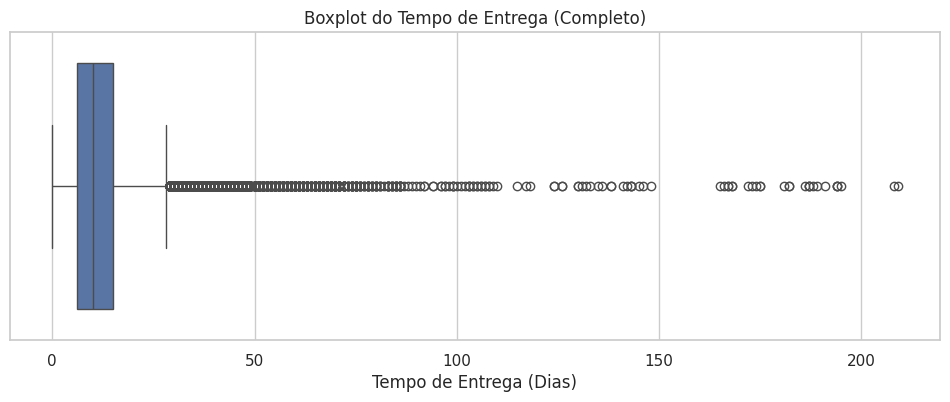

In [ ]:
# --- Boxplot com todos os dados (para ver o efeito dos outliers) ---
plt.figure(figsize=(12, 4))
sns.boxplot(x=df_vendas['tempo_entrega_dias'])
plt.title('Boxplot do Tempo de Entrega (Completo)')
plt.xlabel('Tempo de Entrega (Dias)')
plt.savefig('boxplot_tempo_entrega_completo.png')
plt.show()

## Análise dos Boxplots

Boxplot Completo (Visualização dos Outliers):

Este gráfico confirma a presença de muitos outliers. O "bigode" da direita, que representa o limite superior para dados considerados "normais", termina por volta de 25 dias.

Hipótese Formulada: A presença de entregas que superam 100 dias levanta uma questão de negócio crucial: "Essas entregas extremamente longas estão concentradas em regiões geograficamente mais afastadas do Brasil, ou representam falhas pontuais na logística?". Esta é uma pergunta a ser investigada.

## Boxplot de frete com filtro

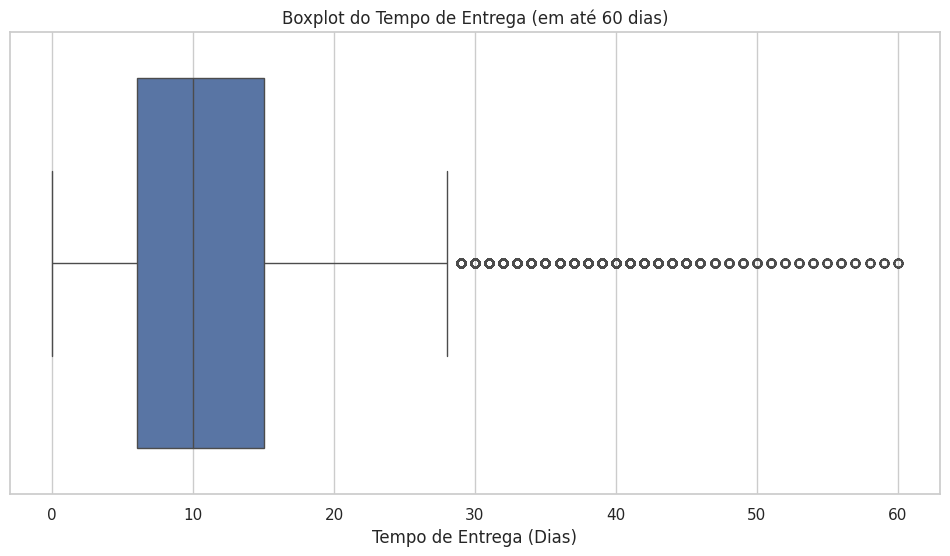

In [ ]:
# --- Boxplot com dados filtrados ---
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_entrega_filtrado['tempo_entrega_dias'])
plt.title('Boxplot do Tempo de Entrega (em até 60 dias)')
plt.xlabel('Tempo de Entrega (Dias)')
plt.savefig('boxplot_tempo_entrega_filtrado.png')
plt.show()

## Boxplot Filtrado (Análise da Distribuição Principal):

O Coração das Entregas: Focando nos dados até 60 dias, o boxplot nos mostra o intervalo interquartil (IQR), que representa o meio da distribuição. Confirmando sua leitura, 50% de todas as entregas ocorrem entre 6 e 15 dias.

Mediana e Assimetria: A mediana (linha central) se confirma em 10 dias. A caixa da direita (entre a mediana e os 75%) é ligeiramente maior que a da esquerda, reforçando a assimetria e mostrando que a variação de tempo é um pouco maior para as entregas que demoram mais de 10 dias.



#Tempo médio de entrega para cada estado e região

In [ ]:
# 1. Dicionário para mapear cada estado (UF) para sua respectiva região
regioes_brasil = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# 2. Agrega os dados por estado para calcular o tempo médio de entrega e o número de pedidos
df_performance_estado = df_vendas.groupby('estado_cliente').agg(
    tempo_medio_entrega=('tempo_entrega_dias', 'mean'),
    numero_de_pedidos=('order_id', 'count')
)

# 3. Adiciona a coluna de região ao DataFrame de estados
df_performance_estado['regiao'] = df_performance_estado.index.map(regioes_brasil)

# 4. Agrupa o DataFrame de estados pela coluna 'regiao' para a análise regional
df_por_regiao = df_performance_estado.groupby('regiao').agg(
    tempo_medio_entrega=('tempo_medio_entrega', 'mean'),
    numero_de_pedidos=('numero_de_pedidos', 'sum')
).sort_values(by='tempo_medio_entrega', ascending=False)


# --- Exibição dos Resultados ---

# Exibe a tabela final, consolidada e arredondada por região
print("Performance Consolidada por Região:")
display(round(df_por_regiao, 1))

# Exibe a tabela de referência por estado, arredondada e ordenada pela entrega mais demorada
print("\n\nPerformance Detalhada por Estado:")
display(round(df_performance_estado.sort_values(by='tempo_medio_entrega', ascending=False), 1))

Performance Consolidada por Região:


,tempo_medio_entrega,numero_de_pedidos
regiao,,
Norte,23.1,2011
Nordeste,20.1,10052
Centro-Oeste,15.0,6463
Sul,13.6,15820
Sudeste,12.4,75534




Performance Detalhada por Estado:


,tempo_medio_entrega,numero_de_pedidos,regiao
estado_cliente,,,
RR,28.3,45,Norte
AP,27.8,81,Norte
AM,26.0,163,Norte
AL,24.0,426,Nordeste
PA,23.3,1048,Norte
MA,21.2,791,Nordeste
SE,20.9,372,Nordeste
CE,20.5,1420,Nordeste
AC,20.3,91,Norte


## Gráfico de tempo médio de entrega

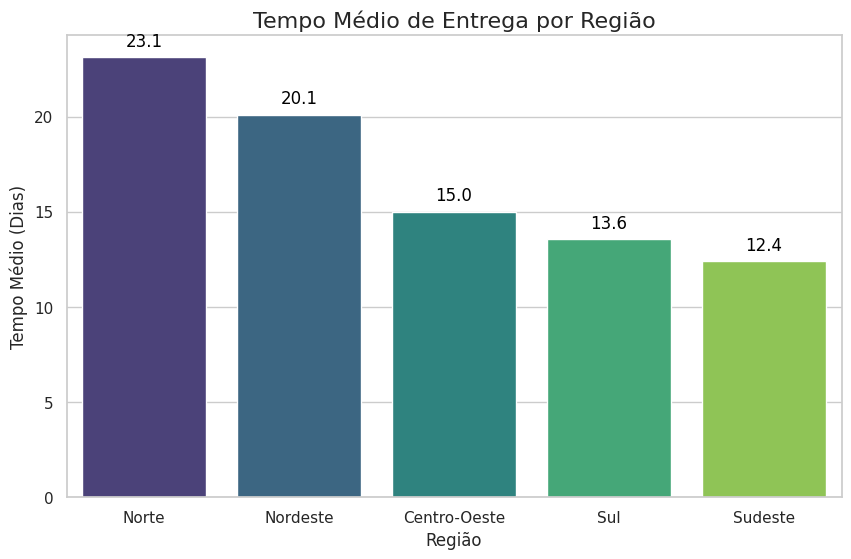

In [ ]:
# Define o estilo do gráfico
sns.set_theme(style="whitegrid")

# Cria a figura e os eixos do gráfico
plt.figure(figsize=(10, 6))

# Adicionamos hue=df_por_regiao.index e legend=False para seguir a nova prática do Seaborn
ax = sns.barplot(x=df_por_regiao.index, y='tempo_medio_entrega', data=df_por_regiao, palette='viridis', hue=df_por_regiao.index, legend=False)

# Loop para adicionar os rótulos (continua igual)
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.annotate(f'{y:.1f}', (x, y), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Adiciona títulos e rótulos
plt.title('Tempo Médio de Entrega por Região', fontsize=16)
plt.ylabel('Tempo Médio (Dias)', fontsize=12)
plt.xlabel('Região', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig('barras_tempo_entrega_regiao.png')
plt.show()

## Insights e Hipóteses Estratégicas:

A análise da tabela consolidada por região revelou os seguintes pontos:

### Desafios Logísticos (Norte e Nordeste):

Observação: As regiões Norte e Nordeste apresentam os maiores tempos médios de entrega (23,1 e 20,1 dias, respectivamente).

Hipótese: Levanta-se a suspeita de que os outliers de frete e tempo de entrega, observados anteriormente, estejam concentrados nessas regiões. Isso sugere que a distância dos centros de distribuição é um fator crítico na operação.

Oportunidade de Negócio: Apesar do desafio logístico, a região Nordeste se destaca como o terceiro maior mercado em número de pedidos. Este dado sugere um potencial de crescimento reprimido. A implementação de um centro de distribuição na região poderia drasticamente reduzir o tempo e o custo do frete, possivelmente destravando um crescimento ainda maior de vendas.





### O Pilar do Negócio (Sudeste):

Observação: A região Sudeste domina o volume de vendas, respondendo por mais de 75 mil dos pedidos analisados. O estado de São Paulo, em particular, apresenta uma combinação poderosa de altíssimo volume (46.338 pedidos) e o menor tempo médio de entrega (8,2 dias).

Implicação Estratégica: O Sudeste é o motor financeiro da empresa. Estratégias de retenção de clientes e otimização de marketing (como tráfego pago direcionado) nesta região são cruciais para a sustentabilidade do negócio.

###Perguntas para Análises Futuras:

Hipótese Causal: O sucesso de São Paulo é impulsionado pelo frete barato, pelo tempo de entrega rápido, ou por uma combinação de ambos?

Análise Preditiva: Qual é a correlação entre o preço do frete e o volume de vendas em uma determinada região? Seria possível usar regressão linear ou outros métodos estatísticos para modelar o impacto de uma redução no frete sobre a receita?

# Pedidos por região

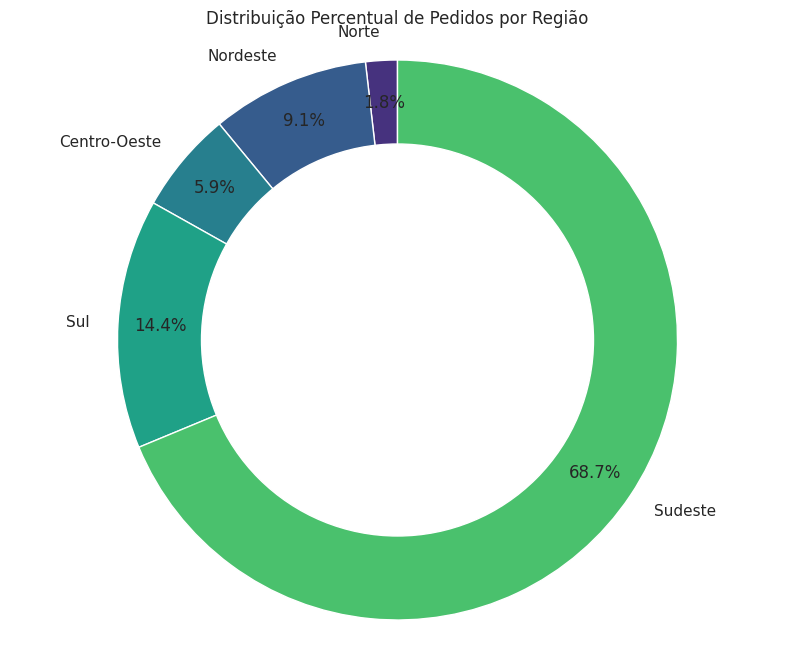

In [ ]:
# Define o estilo e a paleta de cores
sns.set_theme(style="whitegrid", palette="viridis")

# Pega os dados da nossa tabela por região
dados_pizza = df_por_regiao['numero_de_pedidos']
labels_pizza = df_por_regiao.index

# Cria a figura
plt.figure(figsize=(10, 8))

# Cria o gráfico de pizza
plt.pie(dados_pizza, labels=labels_pizza, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Adiciona um círculo no centro para criar um gráfico de "donut" (esteticamente mais agradável)
circulo_central = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circulo_central)

# Adiciona um título
plt.title('Distribuição Percentual de Pedidos por Região')

# Garante que o gráfico seja um círculo
plt.axis('equal')

# Salva a imagem
plt.savefig('pizza_pedidos_regiao.png')

# Mostra o gráfico
plt.show()

# Receita por região

In [ ]:
# Adicionando a coluna 'regiao' diretamente ao nosso DataFrame principal 'df_vendas'
# Metódo .get() para evitar erros caso a coluna já exista
if 'regiao' not in df_vendas.columns:
    df_vendas['regiao'] = df_vendas['estado_cliente'].map(regioes_brasil)

# Agrupamento do df_vendas pela região e soma a receita
df_receita_regiao = df_vendas.groupby('regiao')['valor_total_pagamento'].sum().sort_values(ascending=False)

# Formatação como um DataFrame para melhor visualização
df_receita_regiao = df_receita_regiao.reset_index()
df_receita_regiao.rename(columns={'valor_total_pagamento': 'receita_total'}, inplace=True)

# Calculo do percentual da receita total
df_receita_regiao['percentual_receita'] = (df_receita_regiao['receita_total'] / df_receita_regiao['receita_total'].sum()) * 100

print("Receita Total e Percentual por Região:")
display(df_receita_regiao)

Receita Total e Percentual por Região:


,regiao,receita_total,percentual_receita
0,Sudeste,12738864.15,64.617072
1,Sul,2895338.67,14.686420
2,Nordeste,2272950.20,11.529394
3,Centro-Oeste,1325938.49,6.725738
4,Norte,481302.37,2.441375


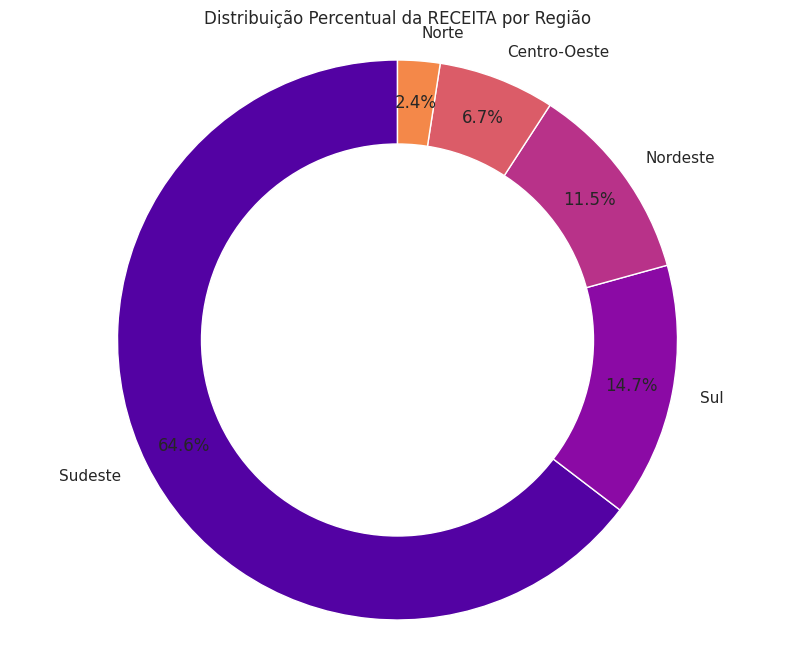

In [ ]:
# Define o estilo e a paleta de cores
sns.set_theme(style="whitegrid", palette="plasma")

# Pega os dados da tabela de receita por região
dados_pizza_receita = df_receita_regiao['receita_total']
labels_pizza_receita = df_receita_regiao['regiao']

# Cria a figura
plt.figure(figsize=(10, 8))

# Cria o gráfico de pizza
plt.pie(dados_pizza_receita, labels=labels_pizza_receita, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Adiciona um círculo no centro para criar um gráfico de "donut"
circulo_central = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circulo_central)

# Adiciona um título claro, especificando que é sobre a RECEITA
plt.title('Distribuição Percentual da RECEITA por Região')

# Garante que o gráfico seja um círculo
plt.axis('equal')

# Salva a imagem
plt.savefig('pizza_receita_regiao.png')

# Mostra o gráfico
plt.show()

## Análise do Ticket Médio e Comportamento de Compra Regional
Uma análise comparativa entre a distribuição percentual de pedidos e de receita por região revelou uma importante nuance no comportamento do consumidor em diferentes partes do Brasil.

Observação Principal:
Enquanto a Região Sudeste detém uma participação percentual na receita (64.6%) ligeiramente inferior à sua participação em número de pedidos (68.7%), as demais regiões (Norte, Nordeste, Centro-Oeste e Sul) apresentam uma participação na receita superior à sua participação em volume.



## Insight: Variação no Ticket Médio Regional

Essa discrepância indica que o Ticket Médio (Average Order Value - AOV), ou o valor médio por transação, é mais baixo no Sudeste em comparação com o restante do país. Em outras palavras, embora os clientes do Sudeste comprem com maior frequência, os consumidores das outras regiões tendem a gastar um valor maior em cada compra individual.



##Hipóteses de Negócio:

Esta variação no comportamento de compra pode ser atribuída a diferentes fatores, que servem como hipóteses para investigações futuras:

Impacto do Custo do Frete: Em regiões com custos de envio mais elevados e prazos mais longos (Norte, Nordeste), os consumidores podem ser incentivados a consolidar mais itens em um único pedido para otimizar o valor do frete, elevando o Ticket Médio.

Competitividade Regional: A Região Sudeste, por ser um mercado mais competitivo e com maior acesso a lojas físicas, pode levar os consumidores a utilizarem a plataforma para compras de menor valor e maior conveniência. Em contrapartida, em regiões com menor disponibilidade de produtos, a plataforma pode ser o canal principal para aquisições de maior valor e mais planejadas.

Mix de Produtos: É possível que haja uma variação no portfólio de produtos mais vendidos entre as regiões. Um maior volume de vendas de itens de baixo custo no Sudeste, em comparação com a venda de produtos de maior valor agregado em outras regiões, impactaria diretamente o Ticket Médio.

##Conclusão e Implicações Estratégicas:

A análise demonstra que a Olist atende a perfis de mercado distintos. A Região Sudeste se caracteriza como um mercado de alto volume e alto giro, enquanto as demais regiões, com destaque para o Nordeste, apresentam um perfil de menor volume, mas maior valor por transação.

Este insight acarreta implicações diretas para a estratégia de marketing e vendas da empresa:

Estratégia para o Sudeste: As ações de marketing podem ser direcionadas para o aumento da frequência de compra e retenção, utilizando promoções de volume (ex: "Leve 3, Pague 2") e programas de fidelidade.

Estratégia para as Demais Regiões: O foco pode ser em aumentar o valor percebido do carrinho, incentivando a compra de kits, combos de produtos e comunicando ativamente o benefício de diluir o custo do frete com compras maiores.

# Análise RFM (Recência, Frequência, Valor Monetário)

RFM é uma técnica usada para classificar e agrupar clientes com base no seu comportamento de compra. Nós vamos atribuir uma nota para cada cliente em três dimensões:

Recência (R): Quão recentemente o cliente fez uma compra? (Clientes que compraram há pouco tempo são mais valiosos).

Frequência (F): Com que frequência ele compra? (Clientes que compram sempre são mais engajados).

Valor Monetário (M): Quanto dinheiro ele já gastou no total? (Clientes que gastam mais são mais lucrativos).

Com o RFM, podemos identificar e criar estratégias para:

Clientes Campeões: Nossos melhores clientes. Precisamos mimá-los!

Clientes em Risco: Eram bons, mas não compram há um tempo. Precisamos reativá-los!

Clientes Novos: Fizeram a primeira compra. Precisamos incentivá-los a voltar!

Clientes Hibernando: Compraram pouco e há muito tempo. Talvez uma oferta agressiva os traga de volta.

In [ ]:
from datetime import datetime

# Define a 'data de hoje' como um dia depois da última compra
hoje = df_vendas['data_compra'].max() + pd.Timedelta(days=1)

# Agrupa os dados pelo ID ÚNICO do cliente
df_rfm = df_vendas.groupby('customer_unique_id').agg(
    # Recência: Calcula os dias desde a última compra
    recencia=('data_compra', lambda date: (hoje - date.max()).days),
    # Frequência: Conta o número de pedidos únicos
    frequencia=('order_id', 'nunique'),
    # Monetário: Soma o valor total de todos os pagamentos
    monetario=('valor_total_pagamento', 'sum')
).reset_index()

# Exibe o describe() da tabela RFM CORRETA
print("Estatísticas da tabela RFM:")
display(df_rfm[['recencia', 'frequencia', 'monetario']].describe())

Estatísticas da tabela RFM:


,recencia,frequencia,monetario
count,93104.000000,93104.000000,93104.000000
mean,236.702924,1.033371,211.745939
std,150.942219,0.209012,642.711305
min,1.000000,1.000000,9.590000
25%,114.000000,1.000000,63.740000
50%,218.000000,1.000000,112.950000
75%,345.000000,1.000000,201.650000
max,602.000000,15.000000,109312.640000


## **Análise das Estatísticas Descritivas da Tabela RFM:**

A tabela de estatísticas descritivas do DataFrame df_rfm revelou insights cruciais sobre o comportamento da base de clientes:

Recência (R): Os valores variam amplamente, com um mínimo de 1 dia (cliente mais recente) e um máximo de 602 dias (cliente mais antigo). A média de 236 dias indica que, em geral, os clientes não realizaram compras muito recentes, o que é esperado dado o período de tempo coberto pelo dataset.

Frequência (F): Esta é a descoberta mais impactante da análise. Com uma mediana (50%) e um terceiro quartil (75%) iguais a 1.0, os dados provam que mais de 75% de toda a base de clientes realizou apenas uma única compra. O valor máximo de 15 compras mostra que existe um pequeno, mas valioso, grupo de clientes recorrentes.

Monetário (M): Assim como o preço dos itens, o gasto total por cliente é assimétrico. A média (R$ 211,74) é quase o dobro da mediana (R\$ 112,95), indicando que um pequeno número de clientes que gastam muito ("heavy-spenders") puxa a média para cima. O valor máximo de R\$ 109.312,64 é um outlier extremo, provavelmente representando uma compra B2B ou de um revendedor.

###Principal Conclusão de Negócio:

A análise da frequência expõe o principal desafio estratégico da empresa: a baixa retenção de clientes. A grande maioria dos consumidores não retorna para uma segunda compra. Isso sugere que o foco do negócio deve ser em estratégias de fidelização para aumentar o Lifetime Value (LTV) do cliente, em vez de focar apenas na aquisição de novos clientes.

In [ ]:
# --- Calcular as pontuações (scores) de R, F e M ---

# Para Recência, usamos qcut. Menor valor de recência = maior score. Por isso as labels são [4, 3, 2, 1].
df_rfm['R_Score'] = pd.qcut(df_rfm['recencia'], q=4, labels=[4, 3, 2, 1])

# Para Frequência, a maioria dos valores é 1, então qcut não funciona. Criamos uma regra manual.
# Clientes com 1 compra = nota 1; 2 compras = nota 2; 3 compras = nota 3; 4 ou mais = nota 4.
def frequencia_score(f):
    if f == 1:
        return 1
    elif f == 2:
        return 2
    elif f == 3:
        return 3
    else: # > 3
        return 4
df_rfm['F_Score'] = df_rfm['frequencia'].apply(frequencia_score)


# Para Monetário, usamos qcut. Maior valor monetário = maior score. Labels [1, 2, 3, 4].
df_rfm['M_Score'] = pd.qcut(df_rfm['monetario'], q=4, labels=[1, 2, 3, 4])


# --- Etapa 3: Exibir os resultados com as novas pontuações ---
print("Tabela RFM com as pontuações R, F e M:")
display(df_rfm.head())

Tabela RFM com as pontuações R, F e M:


,customer_unique_id,recencia,frequencia,monetario,R_Score,F_Score,M_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3


In [ ]:
# Converte os scores para string e os junta em uma única coluna RFM_Score
df_rfm['RFM_Score'] = df_rfm['R_Score'].astype(str) + df_rfm['F_Score'].astype(str) + df_rfm['M_Score'].astype(str)

# Define uma função para mapear os scores RFM para os segmentos de clientes
def classificar_cliente(rfm_score):
    # Usamos expressões regulares para encontrar padrões nos scores
    if pd.Series(rfm_score).str.match(r'[3-4][3-4][3-4]').any():
        return 'Campeões'
    elif pd.Series(rfm_score).str.match(r'[3-4]1[1-4]').any():
        return 'Novos Clientes'
    elif pd.Series(rfm_score).str.match(r'[3-4][1-2][1-4]').any():
        return 'Potenciais Leais'
    elif pd.Series(rfm_score).str.match(r'3[2-3][1-4]').any():
        return 'Precisam de Atenção'
    elif pd.Series(rfm_score).str.match(r'[1-2][3-4][3-4]').any():
        return 'Em Risco'
    elif pd.Series(rfm_score).str.match(r'[1-2][1-2][1-4]').any():
        return 'Hibernando'
    else:
        return 'Outros'

# Aplica a função para criar a coluna de Segmento
df_rfm['Segmento'] = df_rfm['RFM_Score'].apply(classificar_cliente)

# Agrupa por segmento para ver as características de cada um
df_segmentos = df_rfm.groupby('Segmento').agg(
    contagem_clientes=('customer_unique_id', 'count'),
    recencia_media=('recencia', 'mean'),
    frequencia_media=('frequencia', 'mean'),
    receita_media=('monetario', 'mean')
).sort_values(by='contagem_clientes', ascending=False)

print("Tabela Final: Resumo dos Segmentos de Clientes")
display(round(df_segmentos, 2))

Tabela Final: Resumo dos Segmentos de Clientes


,contagem_clientes,recencia_media,frequencia_media,receita_media
Segmento,,,,
Hibernando,46454,361.97,1.03,208.24
Novos Clientes,45030,111.48,1.00,205.04
Potenciais Leais,1393,112.88,2.00,438.13
Campeões,140,106.03,3.56,969.64
Em Risco,79,348.48,3.11,772.02
Outros,8,460.38,3.50,80.05


### Gráfico de RFM

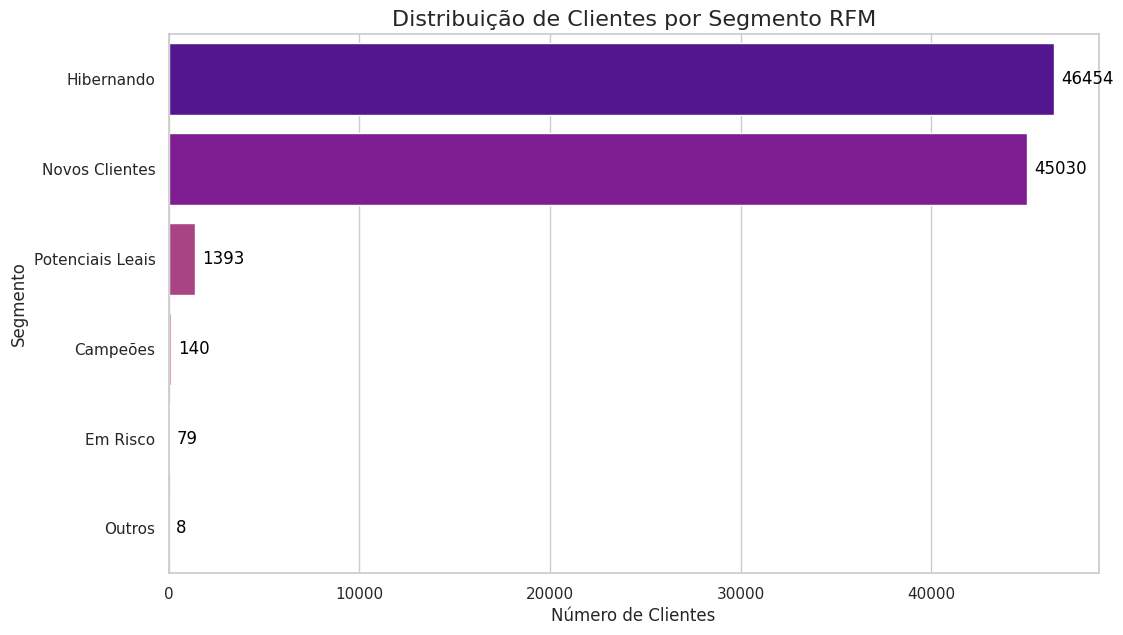

In [ ]:
# Define o estilo
sns.set_theme(style="whitegrid")

# Cria a figura e os eixos
plt.figure(figsize=(12, 7))

# Adicionamos hue=df_segmentos.index e legend=False
ax = sns.barplot(y=df_segmentos.index, x='contagem_clientes', data=df_segmentos, orient='h', palette='plasma', hue=df_segmentos.index, legend=False)

# Loop para adicionar os rótulos (continua igual)
for patch in ax.patches:
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    ax.annotate(f'{int(width)}', (width, y), ha='left', va='center', fontsize=12, color='black', xytext=(5, 0), textcoords='offset points')

# Adiciona títulos e rótulos
plt.title('Distribuição de Clientes por Segmento RFM', fontsize=16)
plt.xlabel('Número de Clientes', fontsize=12)
plt.ylabel('Segmento', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig('barras_segmentos_rfm.png')
plt.show()

## Estratégia dos Segmentos de Clientes (RFM)
A análise RFM permitiu a segmentação da base de 93.104 clientes únicos em grupos distintos, com base em seu comportamento de compra. Cada segmento representa uma oportunidade de negócio e requer uma abordagem de marketing personalizada.



### Definição dos Segmentos:

Campeões (140 clientes):

Quem são: A elite dos clientes. Compraram recentemente, compram com frequência e gastam muito.

Características: R alta, F alta, M alto.

Potenciais Leais (1393 clientes):

Quem são: Clientes recentes que já compraram mais de uma vez, mas ainda não com a frequência ou o valor dos campeões.

Características: R alta, F média/baixa, M variável.

Novos Clientes (45.030 clientes):

Quem são: Clientes que fizeram sua primeira (e única) compra recentemente. São a maior fonte de potenciais clientes leais.

Características: R alta, F baixa.

Precisam de Atenção (Não listado no seu resumo, mas existe):

Quem são: Clientes que compravam com boa frequência ou gastavam bem, mas sua última compra já faz algum tempo.

Características: R média, F média/alta, M médio/alto.

Em Risco (79 clientes):

Quem são: Eram clientes de alta frequência e/ou alto valor, mas não compram há muito tempo. Correm grande risco de serem perdidos para sempre.

Características: R baixa, F alta, M alto.

Hibernando (46.454 clientes):

Quem são: A grande massa de clientes que fizeram uma única compra há muito tempo e nunca mais voltaram.

Características: R baixa, F baixa.



###Plano de Ação Estratégico por Segmento:
Com os segmentos definidos, podemos traçar um plano de ação para aumentar as vendas e a retenção.

Para os "Campeões":

Ação: Tratamento VIP. Acesso antecipado a lançamentos, brindes exclusivos, um programa de fidelidade com benefícios claros. O objetivo não é vender mais, mas sim mantê-los felizes e transformá-los em embaixadores da marca.

Para os "Potenciais Leais" e "Novos Clientes":

Ação: Foco total em incentivar a segunda compra. Oferecer um cupom de desconto de boas-vindas com tempo limitado para a próxima compra. Enviar e-mails com produtos relacionados ao que eles compraram. O objetivo é criar o hábito de comprar na plataforma.

Para os que "Precisam de Atenção" e "Em Risco":

Ação: Campanhas de reativação personalizadas. E-mails como: "Sentimos sua falta! Aqui está um desconto especial para você voltar". Mostrar os novos produtos nas categorias que eles costumavam comprar. O objetivo é reconquistar o cliente antes que ele seja perdido.

Para os "Hibernando":

Ação: Campanhas de marketing em massa com as promoções mais agressivas (ex: Black Friday, Aniversário da Loja). O custo para reativar esses clientes é alto e a chance de sucesso é baixa, então as ações não devem ser personalizadas, mas sim de grande alcance e impacto.

## Extração do RFM para o PowerBI

In [ ]:
import re

# (O DataFrame 'df_vendas' já contem os dados corrigidos e validados)

# 1. Calcular a tabela RFM bruta a partir dos dados corretos
print("Calculando valores RFM...")
hoje = df_vendas['data_compra'].max() + pd.Timedelta(days=1)
df_rfm = df_vendas.groupby('customer_unique_id').agg(
    recencia=('data_compra', lambda date: (hoje - date.max()).days),
    frequencia=('order_id', 'nunique'),
    monetario=('valor_total_pagamento', 'sum')
).reset_index()

# 2. Calcular os Scores RFM
print("Gerando pontuações (Scores)...")
df_rfm['R_Score'] = pd.qcut(df_rfm['recencia'], q=4, labels=[4, 3, 2, 1])
def frequencia_score(f):
    if f == 1: return 1
    elif f == 2: return 2
    elif f == 3: return 3
    else: return 4
df_rfm['F_Score'] = df_rfm['frequencia'].apply(frequencia_score)
df_rfm['M_Score'] = pd.qcut(df_rfm['monetario'], q=4, labels=[1, 2, 3, 4])

# 3. Juntar os scores e definir a função de classificação
df_rfm['RFM_Score'] = df_rfm['R_Score'].astype(str) + df_rfm['F_Score'].astype(str) + df_rfm['M_Score'].astype(str)

def classificar_cliente_corrigido(rfm_score):
    if re.match(r'[3-4][3-4][3-4]', rfm_score):
        return 'Campeões'
    elif re.match(r'[3-4]1[1-4]', rfm_score):
        return 'Novos Clientes'
    elif re.match(r'[3-4][1-2][1-4]', rfm_score):
        return 'Potenciais Leais'
    elif re.match(r'3[2-3][1-4]', rfm_score):
        return 'Precisam de Atenção'
    elif re.match(r'[1-2][3-4][3-4]', rfm_score):
        return 'Em Risco'
    elif re.match(r'[1-2][1-2][1-4]', rfm_score):
        return 'Hibernando'
    else:
        return 'Outros'

# 4. Aplicar a função para criar os segmentos
print("Criando segmentos:")
df_rfm['Segmento'] = df_rfm['RFM_Score'].apply(classificar_cliente_corrigido)

# 5. Exportar o arquivo CSV final e correto
nome_arquivo_rfm = 'dados_rfm_clientes.csv'
df_rfm.to_csv(nome_arquivo_rfm, index=False, encoding='utf-8-sig')

print(f"\nArquivo '{nome_arquivo_rfm}' exportado com sucesso!")
display(df_rfm.head())

Calculando valores RFM...
Gerando pontuações (Scores)...
Criando segmentos:

Arquivo 'dados_rfm_clientes.csv' exportado com sucesso!


,customer_unique_id,recencia,frequencia,monetario,R_Score,F_Score,M_Score,RFM_Score,Segmento
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,413,Novos Clientes
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,311,Novos Clientes
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,Hibernando
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,Hibernando
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,213,Hibernando


## Exportação dos DataFrames Finais

In [ ]:
# --- ETAPA FINAL: EXPORTAR DADOS PARA REPRODUTIBILIDADE ---

# Exporta o DataFrame mestre usado para a maioria das análises e gráficos
df_vendas.to_csv('olist_dados_processados.csv', index=False, encoding='utf-8-sig')

# Exporta o DataFrame final da análise RFM
df_rfm.to_csv('olist_dados_rfm.csv', index=False, encoding='utf-8-sig')

print("Arquivos CSV para o GitHub exportados com sucesso!")

Arquivos CSV para o GitHub exportados com sucesso!


# **Análise e Visualização de Dados no Power BI**

A última fase do projeto consistiu na criação de um dashboard interativo para consolidar e apresentar os insights da análise. A ferramenta escolhida foi o Microsoft Power BI, devido à sua capacidade de modelagem de dados e exploração visual.

## ETL (Extração, Transformação e Carga) com o Power Query

Diferente da abordagem inicial de carregar um único arquivo CSV pré-processado, optou-se por seguir as melhores práticas de Business Intelligence, carregando os arquivos CSV brutos e realizando o tratamento diretamente no Power BI.

### Extração (Extract):
Foram carregadas as seguintes tabelas de dados originais do Kaggle, utilizando o conector "Texto/CSV":

```
olist_orders_dataset.csv

olist_order_items_dataset.csv

olist_order_payments_dataset.csv

olist_products_dataset.csv

olist_customers_dataset.csv
```



### Transformação (Transform):
Todo o processo de transformação e limpeza foi realizado no Editor do Power Query para garantir a qualidade e a consistência dos dados:

####Renomeação de Colunas:
Todas as colunas foram traduzidas do inglês para o português para facilitar a compreensão do modelo e a criação dos visuais (ex: order_status para Status Pedido).

###Correção de Tipos de Dados (Localidade):
Foi identificado que as colunas de valores monetários (ex: payment_value) estavam em formato americano (com . como separador decimal). O tipo de dado foi alterado usando a localidade "Inglês (Estados Unidos)" para garantir a correta interpretação numérica.

###Filtragem de Dados:
Para alinhar a análise com as descobertas da fase exploratória, foram aplicados dois filtros na tabela pedidos:

O Status Pedido foi filtrado para manter apenas "delivered".

A Data Compra foi filtrada para incluir apenas datas posteriores a 31/12/2016.

###Criação de Coluna Personalizada:
Foi criada a coluna Tempo de Entrega (Dias) na tabela pedidos a partir da subtração entre Data de Entrega e Data Compra, transformando o resultado em um número de dias.

### Carga (Load):
Após as transformações, as tabelas foram carregadas no modelo de dados do Power BI.

## Modelagem de Dados e Medidas DAX

### Modelo de Dados (Esquema Estrela):
Na "Exibição de Modelo", as tabelas foram conectadas através de suas chaves (ID Pedido, ID Cliente, etc.) para criar um modelo de dados relacional (esquema estrela). As relações foram configuradas com direção de filtro "Única", garantindo que os filtros fluam das tabelas de dimensão (como pedidos) para as tabelas de fatos (como pagamentos), o que assegura a consistência dos cálculos.

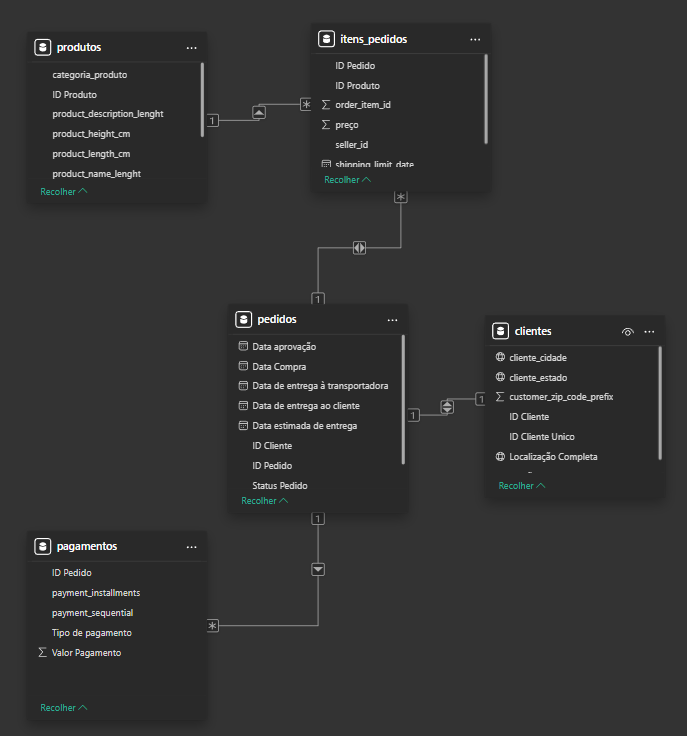

## Criação de Medidas com DAX:
Para garantir cálculos precisos e reutilizáveis, foram criadas as seguintes medidas DAX:

###Clientes únicos com filtro

```
Nº Clientes Únicos (Filtrado) =
CALCULATE(
    DISTINCTCOUNT('clientes'[ID Cliente Unico]),
    'pedidos'[Status Pedido] = "delivered",
    'pedidos'[Data Compra] > DATE(2016, 12, 31)
)
```



### Receita Total:
Utiliza a função CALCULATE para somar os valores da tabela pagamentos, aplicando os mesmos filtros de status e data da tabela pedidos, garantindo a integridade do cálculo independentemente do contexto do filtro no modelo.



```
Receita Filtrada (DAX) =
CALCULATE(
    SUM('pagamentos'[Valor Pagamento]),
    'pedidos'[Status Pedido] = "delivered",
    'pedidos'[Data Compra] > DATE(2016, 12, 31)
)
```



### Nº Total de Pedidos


```
Nº Total de Pedidos = DISTINCTCOUNT('pedidos'[ID Pedido])
```

###Ticket Médio:
Reutiliza as medidas já criadas para garantir consistência.



```
Ticket Médio =
DIVIDE(
    [Receita Filtrada (DAX)],
    [Nº Total de Pedidos]
)
```



###Tempo Médio de Entrega


```
Tempo Médio de Entrega = AVERAGE('pedidos'[Tempo de Entrega (Dias)])
```



## Analises do PowerBI

###Cartões de KPIs (Indicadores-Chave de Desempenho):

Objetivo: Apresentar os números mais importantes do negócio de forma imediata e clara.

Métricas Exibidas:

**Receita Total**: O faturamento total para o período analisado (pós-2016, pedidos entregues).

**Nº Total de Pedidos**: A contagem distinta de pedidos concluídos.

**Nº Clientes Únicos**: A contagem de clientes únicos, que, quando comparada ao Nº de Pedidos, evidencia a baixa taxa de recompra.

**Ticket Médio**: O valor médio gasto por pedido, indicando o comportamento de compra geral.

**Tempo Médio de Entrega**: O tempo médio em dias entre a compra e a entrega, medindo a eficiência logística.

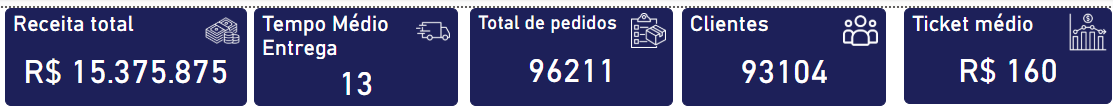

### Análise Temporal da Receita (Gráfico de Linhas)

A visualização da receita ao longo do tempo permitiu identificar três fases distintas do negócio no período analisado:

###Fase de Crescimento Acelerado (2017):
O ano de 2017 demonstrou uma clara e consistente tendência de crescimento, culminando em um pico de faturamento em Novembro (R\$ 1,15 Mi), o que confirma o forte impacto da sazonalidade da Black Friday nas vendas. A queda em Dezembro (R\$ 0,84 Mi) é um comportamento esperado após a antecipação de compras do mês anterior.

###Fase de Maturação e Estabilidade
(1º Semestre de 2018): O negócio inicia 2018 em um novo patamar de faturamento, com as vendas se estabilizando em torno de R$ 1 a 1,13 Milhão por mês. Isso indica que a empresa conseguiu reter uma parte do crescimento obtido no ano anterior.

###Fase de Potencial Declínio (2º Semestre de 2018):
Os últimos três meses disponíveis no dataset (Junho a Agosto) mostram uma leve tendência de queda no faturamento.

###Limitação da Análise:
Conforme observado, o dataset se encerra em Agosto de 2018. Isso impede a análise de um ciclo anual completo para 2018, impossibilitando a confirmação do padrão de sazonalidade de Novembro e a comparação do crescimento ano a ano (Year-over-Year).

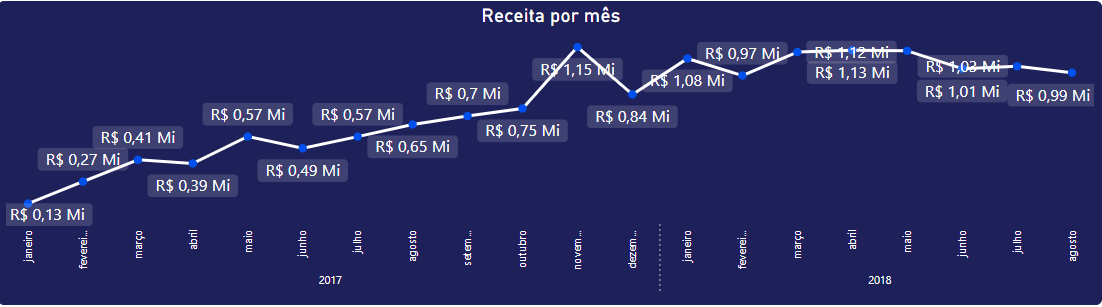

###Distribuição Geográfica de Pedidos (Preenchimento de Mapa):

Objetivo: Identificar a concentração geográfica das vendas no território brasileiro.

Insights: O mapa coroplético (de preenchimento) destaca a massiva dominância da Região Sudeste, especialmente o estado de São Paulo, como o principal mercado da empresa. Fica evidente a concentração das vendas no litoral, com menor penetração no interior do país.

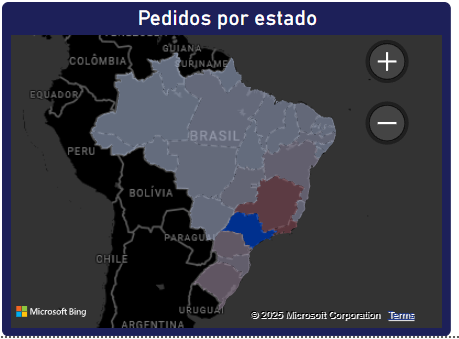

###Top 10 Categorias por Receita (Gráfico de Barras):

Objetivo: Rankear as categorias de produtos que mais contribuem para o faturamento da empresa.

Insights: O gráfico permite a identificação rápida dos "carros-chefe" do negócio, direcionando estratégias de estoque e marketing para os segmentos de produtos mais lucrativos.

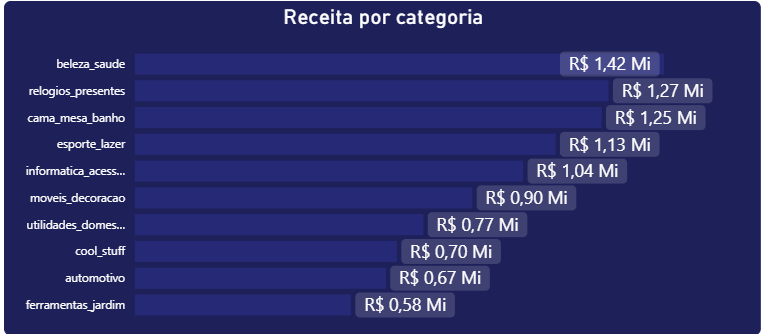

###Filtros Interativos (Segmentação de Dados):

Objetivo: Transformar o relatório de uma visualização estática para uma ferramenta de exploração dinâmica.

Filtros Implementados:

Período (Data Compra): Um filtro que permite ao usuário analisar o intervalo de tempo desejado, aprofundando a análise de sazonalidade ou performance de campanhas.

Região: Um filtro que permite segmentar todos os visuais do dashboard para uma região específica, facilitando a análise comparativa do comportamento do consumidor e da logística em diferentes mercados.

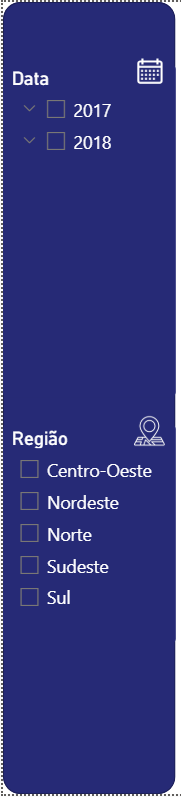

## Análise de Clientes (RFM): Modelagem e Preparação dos Dados

Para enriquecer o dashboard com a segmentação de clientes, foi necessário importar a tabela dados_rfm_clientes.csv (gerada na etapa de análise em Python) para o modelo do Power BI.

Desafio: Erro de Cardinalidade na Relação

Ao tentar criar a relação entre a tabela clientes (dados brutos) e a nova tabela RFM através da coluna ID Cliente Único, o Power BI retornou um erro de cardinalidade. A investigação confirmou que a tabela clientes continha ID Cliente Único duplicados.

Causa Raiz: O dataset original da Olist registra uma nova linha na tabela clientes sempre que um cliente único realiza uma compra para um novo endereço. Isso faz com que a tabela clientes não seja uma lista de clientes únicos, mas sim uma lista de "clientes-por-localização", quebrando a unicidade necessária para o lado "um" de uma relação.

Solução Implementada no Power Query:

Para resolver o problema e criar uma tabela de dimensão de clientes (DimCliente) válida, foi aplicado um passo de transformação no Power Query:

Seleção da Tabela: A consulta da tabela clientes foi selecionada.

Remoção de Duplicatas: Com a coluna ID Cliente Único selecionada, foi utilizada a função "Remover Linhas" > "Remover Duplicados".

Este procedimento garantiu a criação de uma tabela onde cada cliente é representado por uma única linha, permitindo a criação de uma relação Um-para-Um (1:1) entre a tabela clientes e a tabela RFM.

Com o modelo de dados corrigido e a relação estabelecida, o dashboard está pronto para a criação de visuais baseados nos segmentos de clientes.

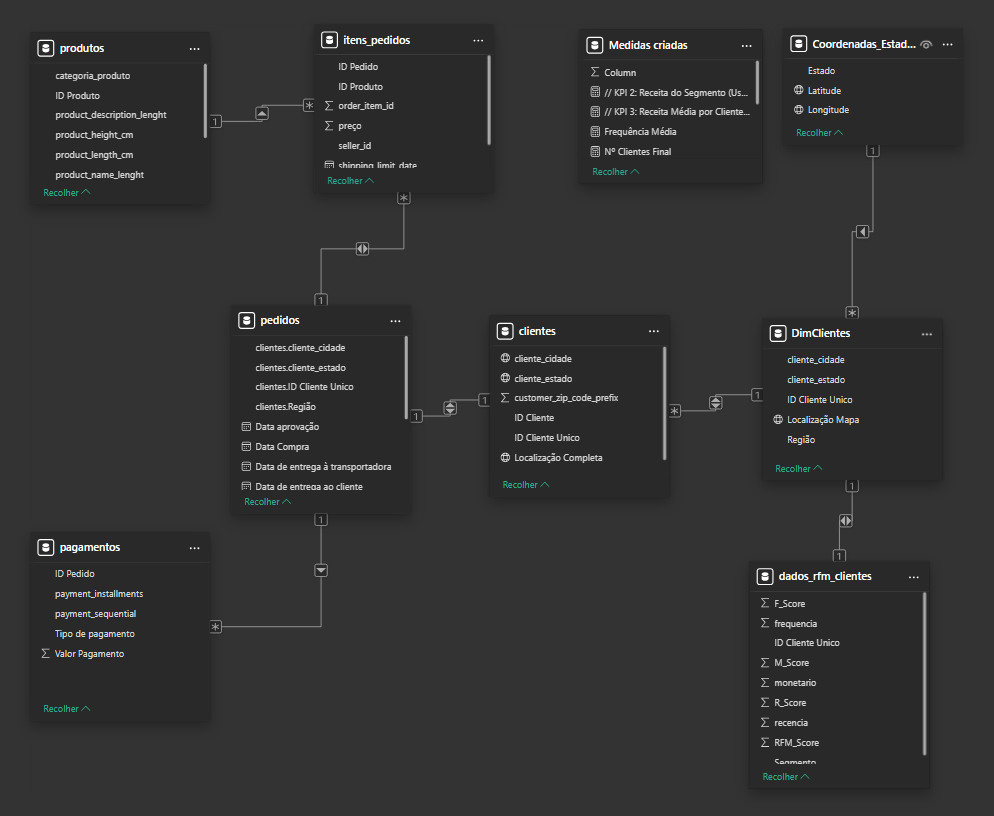

## Página 2: Análise de Clientes (RFM)

Objetivo: Fornecer uma ferramenta interativa para que a área de negócio possa explorar os segmentos de clientes, entender suas características e direcionar ações de marketing.

Funcionalidades:

KPIs Dinâmicos: Cartões que se atualizam em tempo real para mostrar o Número de Clientes, a Receita Total, Frequência média e o Ticket Médio do segmento selecionado.

Distribuição de Segmentos: Gráficos de barras e rosca que mostram o tamanho de cada segmento, destacando visualmente a enorme base de clientes "Novos" e "Hibernando".

Análise Geográfica: Um mapa interativo que revela a localização dos diferentes segmentos de clientes (ex: onde se concentram os "Campeões").

Tabela de Características: Uma tabela que resume o comportamento médio (Recência, Frequência, Receita Média) de cada segmento, servindo como uma legenda detalhada.

Insight Principal: A página confirma visualmente o desafio da retenção. Ela permite identificar que, embora os "Campeões" sejam poucos, seu valor médio por cliente é ordens de magnitude maior que o de um cliente novo. A página serve como base para o plano de ação estratégico focado em aumentar a fidelidade do cliente.

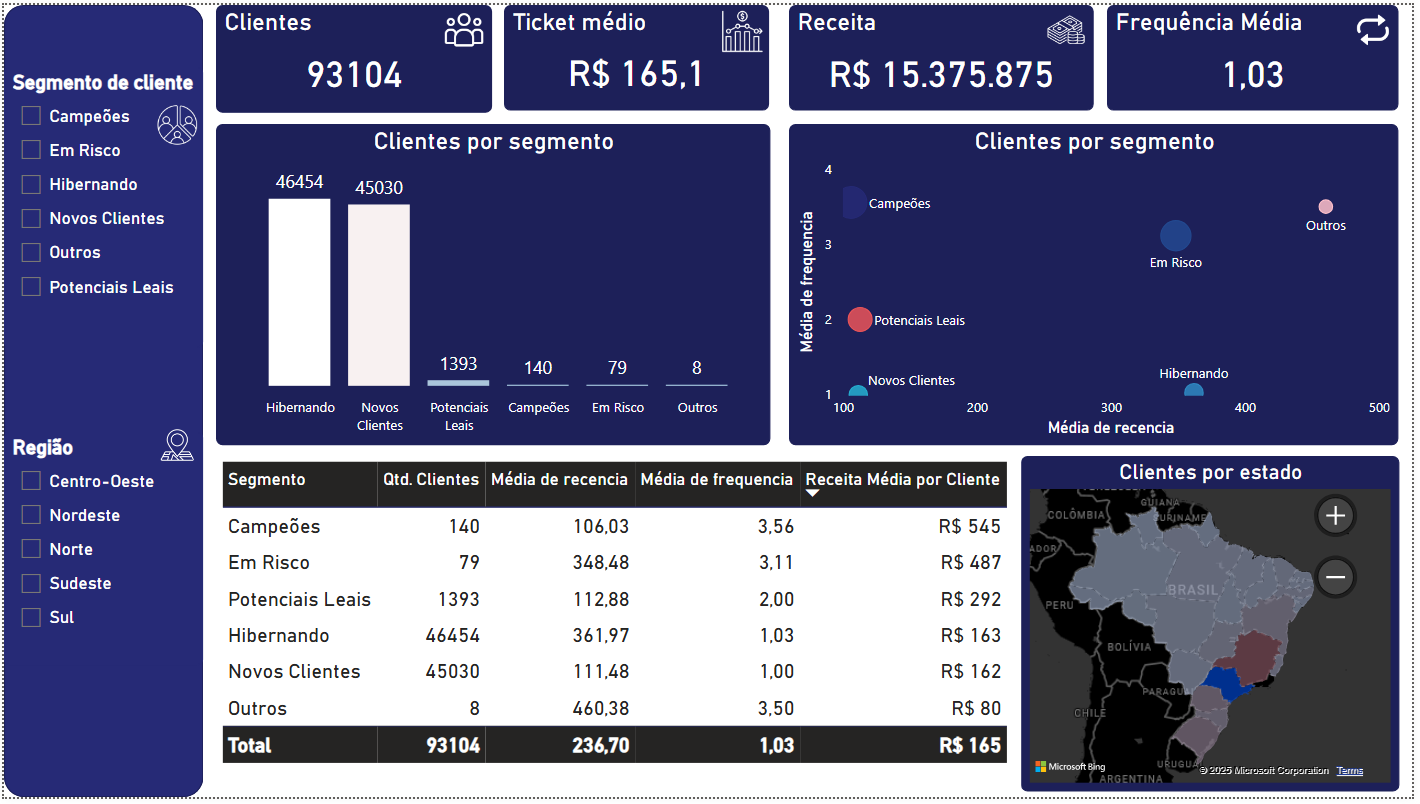

# Conclusão e Recomendações Estratégicas

Este projeto realizou uma análise de ponta a ponta do dataset da Olist, culminando em insights estratégicos e em um dashboard interativo no Power BI. As principais conclusões e recomendações são:


##1. O Negócio é Impulsionado por Volume no Sudeste, mas há oportunidades em outras regiões:

Sazonalidade: A análise temporal revelou uma forte sazonalidade nas vendas, com um pico de faturamento em Novembro, impulsionado pela Black Friday e Natall. Este evento se mostrou crucial para o resultado anual da empresa, indicando a necessidade de um planejamento robusto de estoque e marketing para este período.

Comportamento Regional: O negócio é altamente concentrado na Região Sudeste (69% dos pedidos, 65% da receita). No entanto, a análise do Ticket Médio revelou um comportamento de compra distinto: clientes de regiões mais afastadas (Norte/Nordeste) gastam mais por transação, provavelmente para otimizar os custos de frete.

Recomendação: Sugere-se uma estratégia de marketing e logística dupla:

Sudeste: Focar em aumentar a frequência de compra com ações de fidelidade e promoções de volume.

Nordeste/Norte: Investir em otimizar a logística (potencialmente com um centro de distribuição local) para reduzir frete e prazos, capitalizando sobre o maior valor por compra dos clientes dessas regiões.



## 2. O Maior Desafio do Negócio é a Retenção de Clientes:

Conclusão: A análise de segmentação RFM foi inequívoca ao demonstrar que mais de 98% dos clientes compram apenas uma vez e não retornam. O principal desafio da empresa não é a aquisição, mas a fidelização.

Recomendação: Implementar um plano de ação de marketing direcionado por segmento, utilizando o dashboard de Análise de Clientes (RFM) como ferramenta:

Novos Clientes (48% da base): Foco total em incentivar a segunda compra através de cupons de boas-vindas e comunicação pós-venda.

Campeões (0.15% da base): Tratar como VIPs com programas de fidelidade e benefícios exclusivos para garantir sua retenção, pois seu valor para o negócio é desproporcionalmente alto.

Clientes em Risco e Hibernando: Executar campanhas de reativação personalizadas e em massa, respectivamente, para tentar recuperar uma parte dessa base de clientes perdida.



## 3. O Dashboard como Ferramenta de Decisão:

Conclusão: O projeto culminou na criação de um dashboard no Power BI que não apenas exibe dados, mas permite a exploração interativa.

Recomendação: Utilizar o dashboard como uma ferramenta contínua de monitoramento e análise estratégica, permitindo que as áreas de negócio (Marketing, Vendas, Logística) identifiquem tendências, explorem segmentos e tomem decisões informadas baseadas em dados validados.

# Escopo da Análise e Próximos Passos
O foco principal deste projeto foi a análise estratégica de Vendas e Marketing, com o objetivo de entender o comportamento do consumidor e gerar recomendações para alavancar o crescimento através da fidelização.

Devido a este escopo, outras áreas ricas em potencial analítico foram intencionalmente deixadas para futuras investigações. Os próximos passos lógicos para expandir este projeto seriam:

1. Análise Logística Aprofundada:

Investigar a correlação direta entre o tempo de entrega (real vs. estimado) e a nota da avaliação (review_score) para quantificar o impacto de atrasos na satisfação do cliente.

Mapear os outliers de frete para identificar as rotas e os produtos com os maiores desafios logísticos.

2. Análise de Sentimentos com NLP:

Utilizar técnicas de Processamento de Linguagem Natural (NLP) nos comentários das avaliações para extrair as razões qualitativas por trás das notas. Isso permitiria identificar se os problemas mais comuns são relacionados à entrega, qualidade do produto, ou atendimento do vendedor.

3. Modelagem Preditiva (Machine Learning):

Construir um modelo de previsão de churn para identificar, no momento da primeira compra, quais clientes têm maior probabilidade de não retornar, permitindo ações de marketing proativas.

Desenvolver um modelo de forecasting para prever as vendas dos próximos meses, auxiliando no planejamento de estoque.

4. Análise de Performance dos Vendedores:

Criar uma nova página no dashboard focada nos vendedores para identificar os parceiros de maior e menor performance, permitindo uma gestão de contas mais eficiente.